In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
dataset_name = "W13_comb"

In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)
Wall time: 3.28 s


In [6]:
####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )
try:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
except:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

var_type (5173, 12)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)


In [7]:
fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

In [8]:
## augment dataset
# pan_dataset_values
# census data
# 

pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    

In [9]:
num_to_wave = {x:"W"+str(x) for x in range(1,14)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,14) }
weights = BES_Panel[list(num_to_weight.values())].copy()

In [10]:
# http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]


# len()
census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
census_vars.append("leaveHanretty")
census_vars.append("remainHanretty")
census_vars.append("pano")
# ConstituencyType
BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')


BES_census_data (632, 308)


In [11]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [ ]:
def get_base(im_var, waves=None, noNans = False):

    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
        
    immig_vars = [im_var+x for x in wave_list]
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()
        
        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
        
        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset
        
        
    return BES_immig, all_in_dataset

In [17]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",
             "ukCoopMovement"]

# im_var = "immigCultural"
imvar_list = ["ptvLab"]

num = 0
for im_var in imvar_list:
    immig, mask = get_base(im_var,noNans = False)
    immig.columns = ["Delta_"+x for x in immig.columns]
    if num ==0:
        immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
    else:
        immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1

In [22]:
# lr_pos =  [x for x in BES_reduced.columns if re.match("lrCon|lrLab",x)]
# lr_pos.remove('lrConW10__Right')
# lr_pos

In [21]:
# immigDiff

In [67]:
immigDiff = BES_reduced_with_na[lr_pos].diff(axis=1)[lr_pos[1::2]]

In [ ]:
# lrLab-lrCon

In [38]:
Treatment = "ptvLab"

In [41]:
var_stub = "ptvLab"
var_list = [x for x in immigDiff.columns if var_stub in x]
var_stub_list = ["ptv","like"]
# base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
var_list

['Delta_ptvLabW2',
 'Delta_ptvLabW3',
 'Delta_ptvLabW4',
 'Delta_ptvLabW5',
 'Delta_ptvLabW6',
 'Delta_ptvLabW7',
 'Delta_ptvLabW8',
 'Delta_ptvLabW9',
 'Delta_ptvLabW10',
 'Delta_ptvLabW11',
 'Delta_ptvLabW12',
 'Delta_ptvLabW13']

In [42]:
[x for x in BES_Panel.columns if "ptvLab" in x]

['ptvLabW1',
 'ptvLabW2',
 'ptvLabW3',
 'ptvLabW4',
 'ptvLabW5',
 'ptvLabW6',
 'ptvLabW7',
 'ptvLabW8',
 'ptvLabW9',
 'ptvLabW10',
 'ptvLabW11',
 'ptvLabW12',
 'ptvLabW13']

In [43]:
# var_list = immigDiff.columns
# var_stub_list = ['lrLab','lrCon']

In [44]:
# var_list.remove('partydiffconlabW5__There is not much difference between them')
# var_list = var_list[-2:]

Delta_ptvLabW2 2
missing vals in sample weights: 6
[0]	validation_0-rmse:0.531079
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.513263
[2]	validation_0-rmse:0.496404
[3]	validation_0-rmse:0.480317
[4]	validation_0-rmse:0.464917
[5]	validation_0-rmse:0.450163
[6]	validation_0-rmse:0.436021
[7]	validation_0-rmse:0.422836
[8]	validation_0-rmse:0.410131
[9]	validation_0-rmse:0.398073
[10]	validation_0-rmse:0.386544
[11]	validation_0-rmse:0.375699
[12]	validation_0-rmse:0.365529
[13]	validation_0-rmse:0.35566
[14]	validation_0-rmse:0.34638
[15]	validation_0-rmse:0.337729
[16]	validation_0-rmse:0.329405
[17]	validation_0-rmse:0.321647
[18]	validation_0-rmse:0.31428
[19]	validation_0-rmse:0.307299
MSE: 0.09, MAE: 0.26, EV: 0.00, R2: -1.19


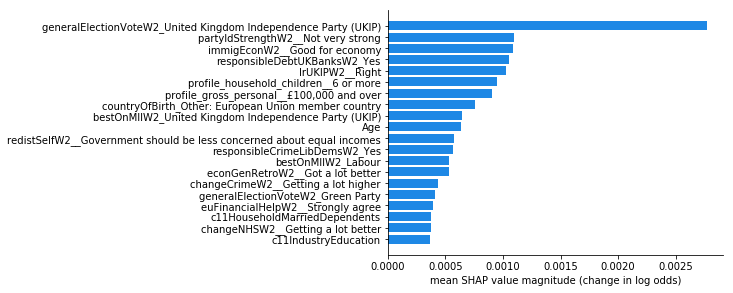

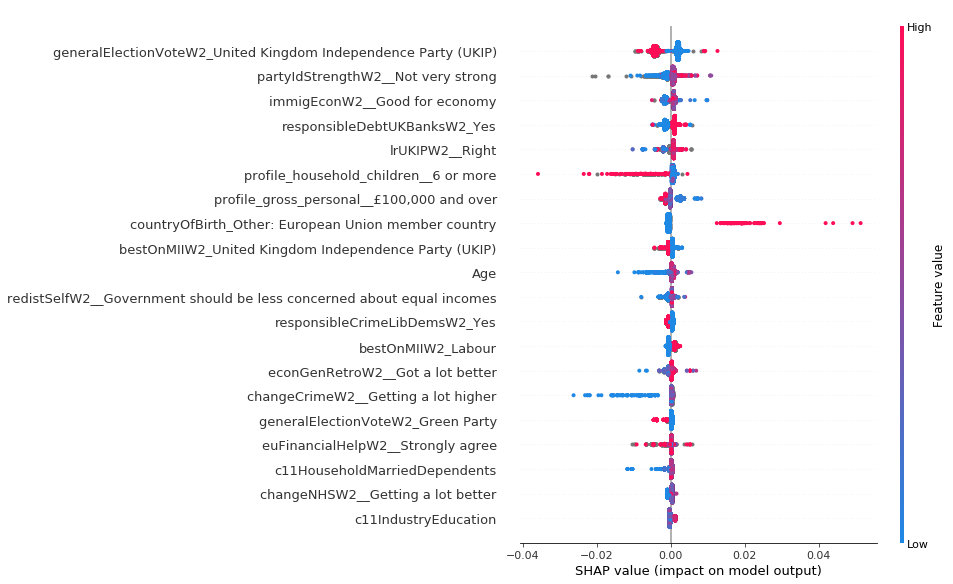

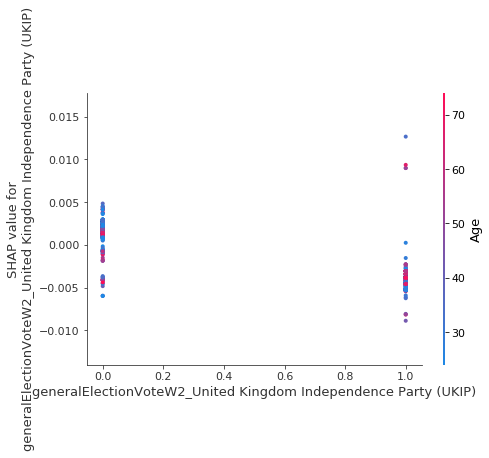

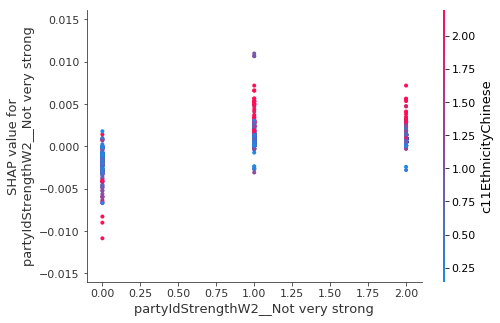

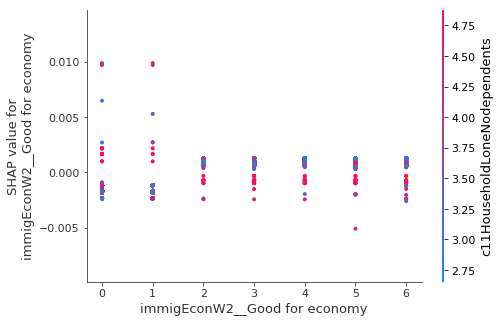

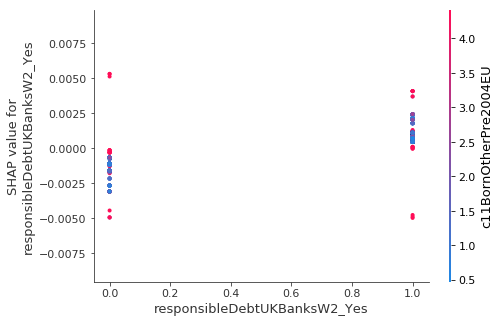

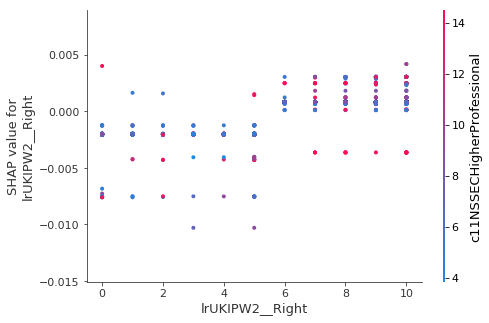

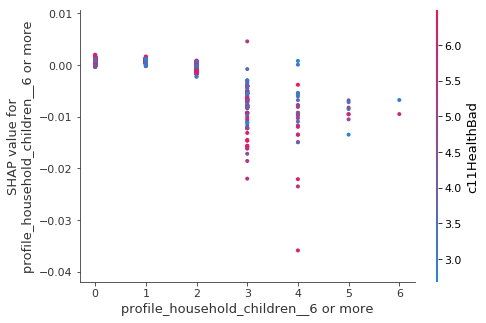

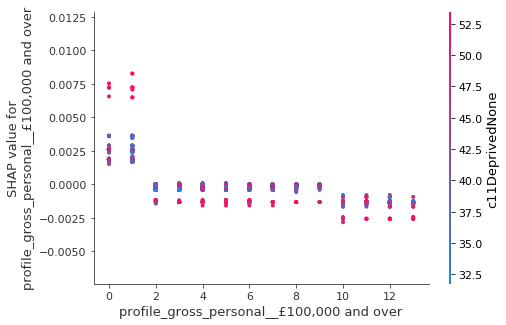

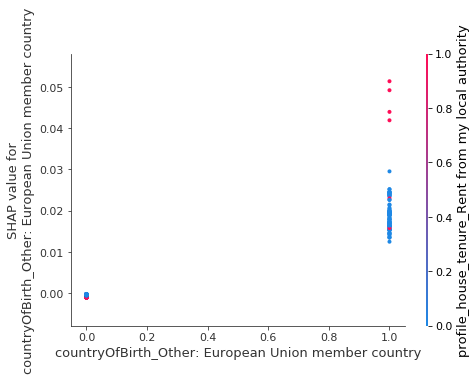

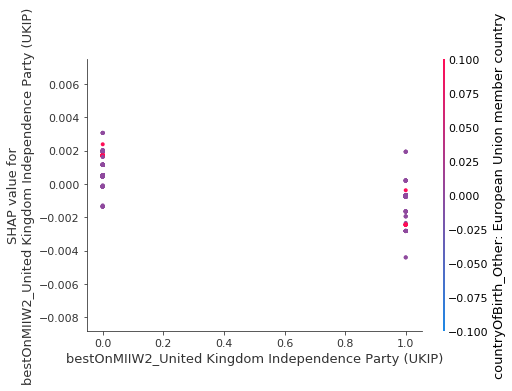

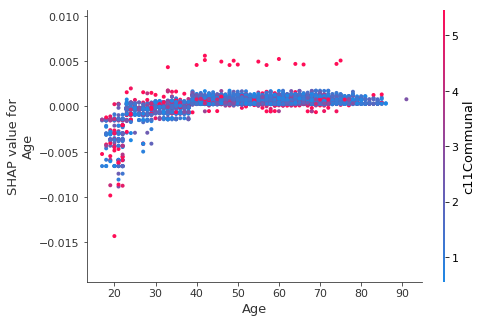

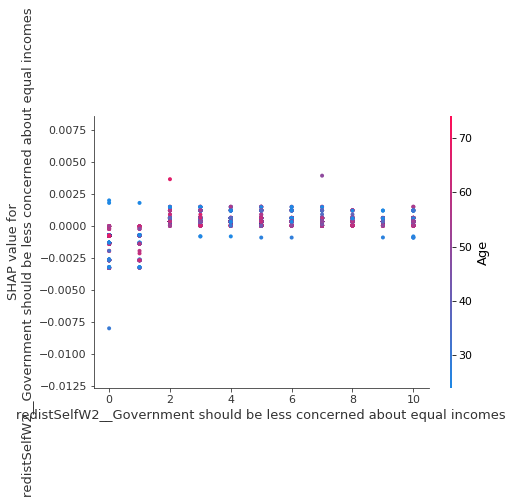

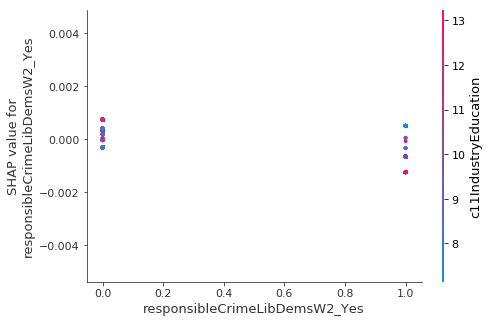

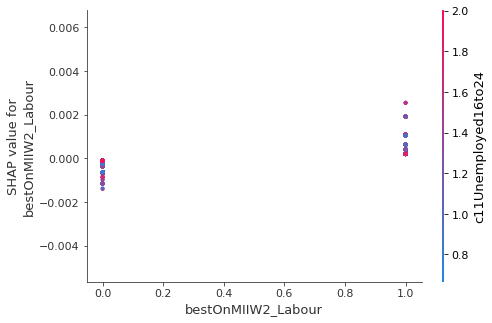

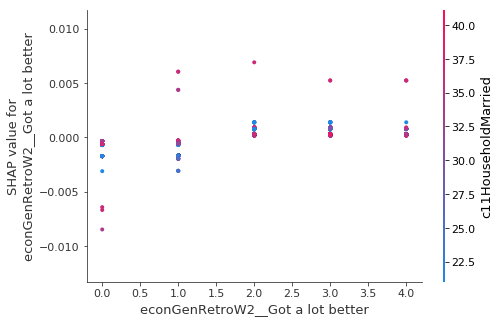

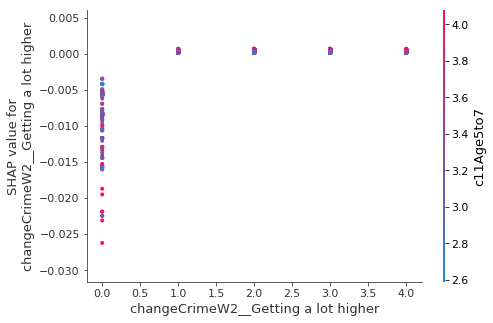

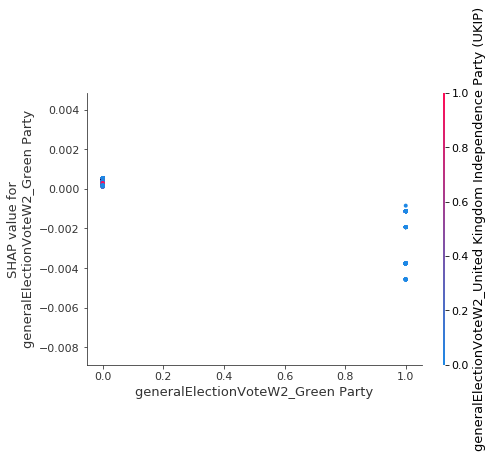

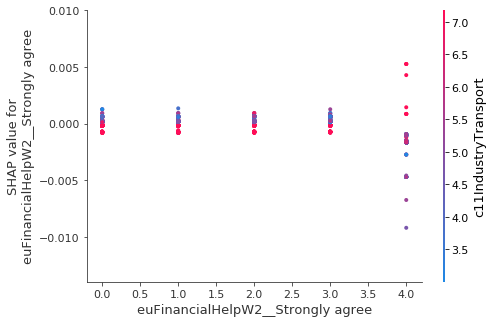

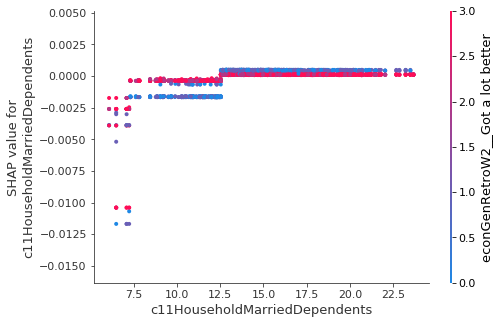

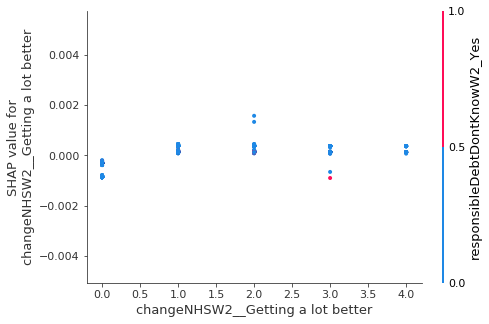

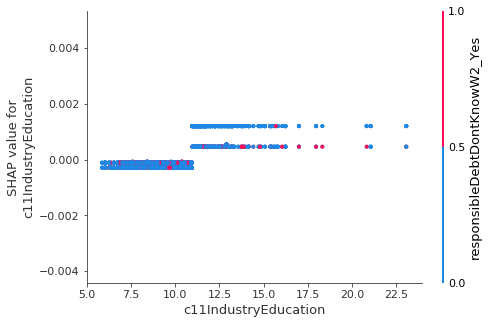

Delta_ptvLabW3 3
missing vals in sample weights: 0
[0]	validation_0-rmse:0.532942
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.514871
[2]	validation_0-rmse:0.497649
[3]	validation_0-rmse:0.481133
[4]	validation_0-rmse:0.465334
[5]	validation_0-rmse:0.450394
[6]	validation_0-rmse:0.436139
[7]	validation_0-rmse:0.422606
[8]	validation_0-rmse:0.40973
[9]	validation_0-rmse:0.39751
[10]	validation_0-rmse:0.385847
[11]	validation_0-rmse:0.374852
[12]	validation_0-rmse:0.36432
[13]	validation_0-rmse:0.354384
[14]	validation_0-rmse:0.344972
[15]	validation_0-rmse:0.336095
[16]	validation_0-rmse:0.327494
[17]	validation_0-rmse:0.319471
[18]	validation_0-rmse:0.311873
[19]	validation_0-rmse:0.304692
MSE: 0.09, MAE: 0.26, EV: 0.04, R2: -1.17


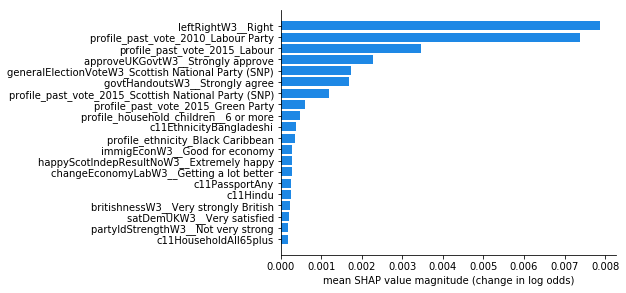

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


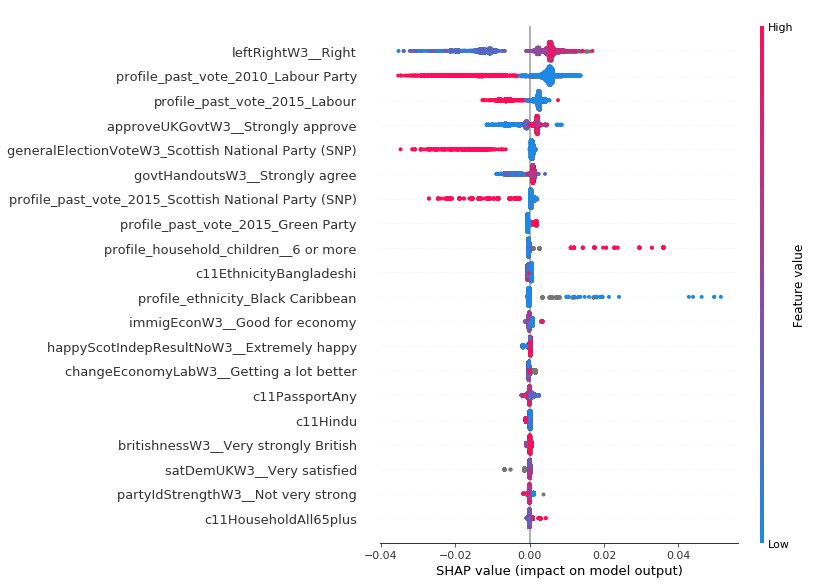

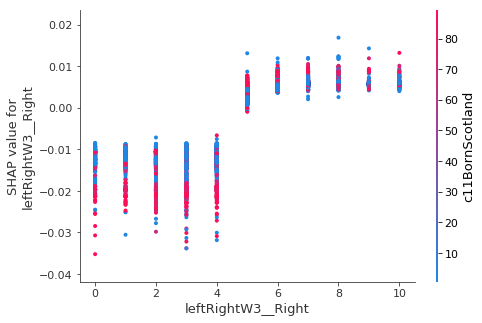

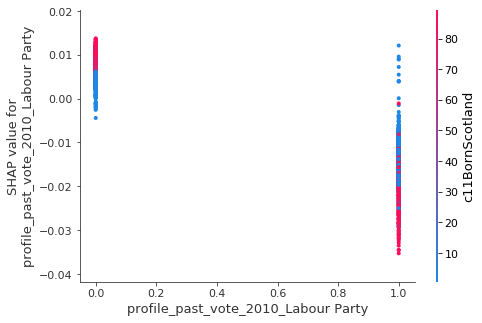

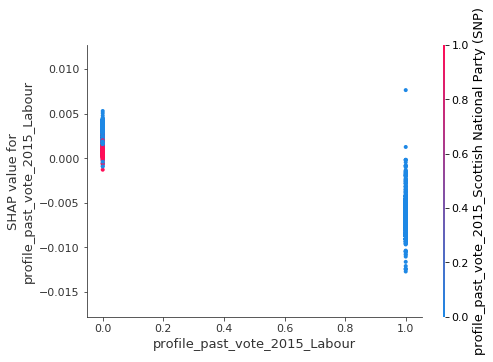

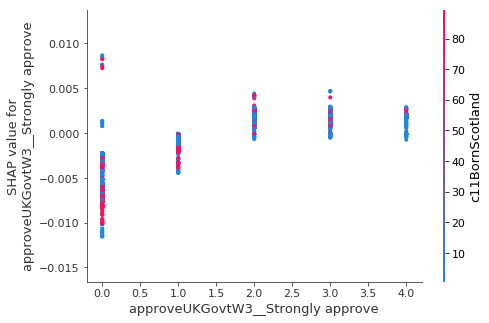

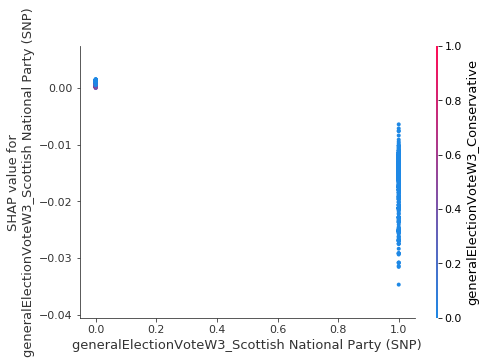

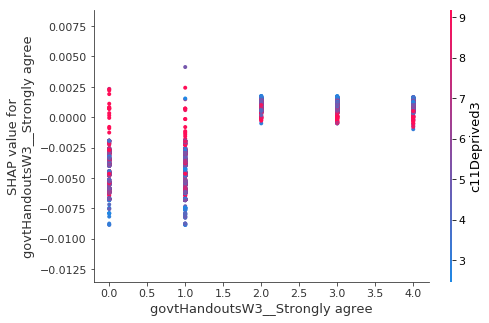

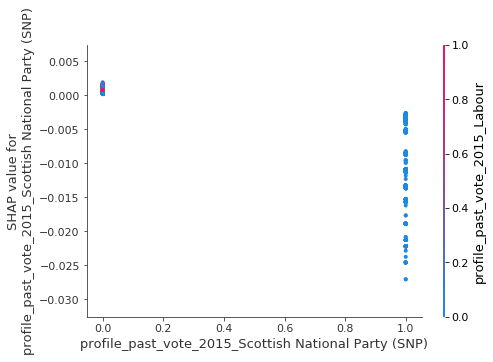

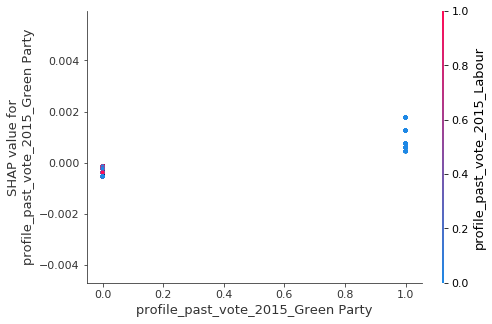

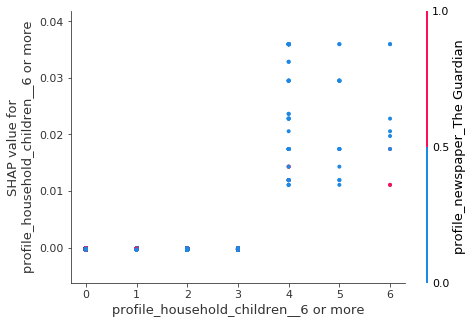

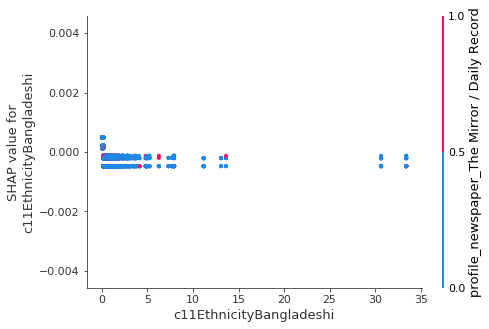

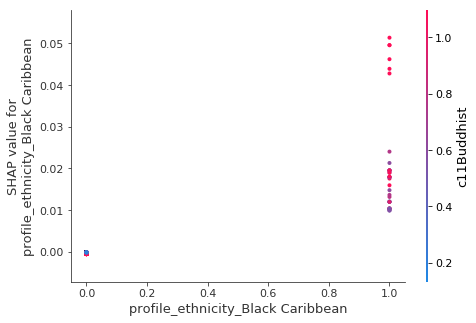

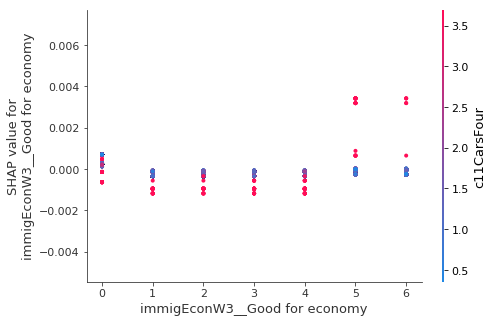

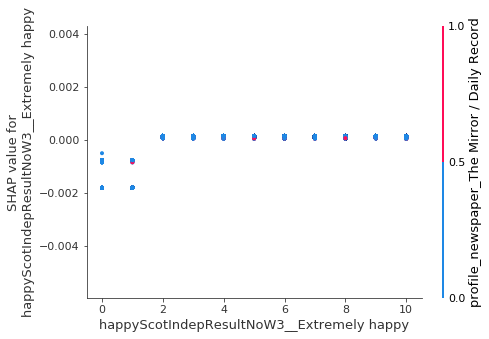

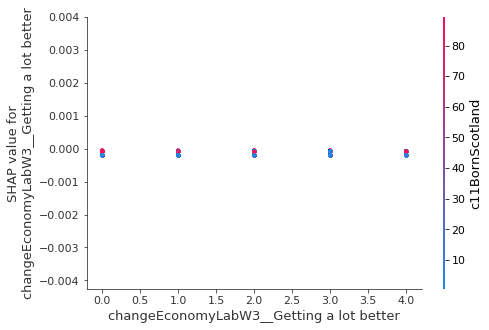

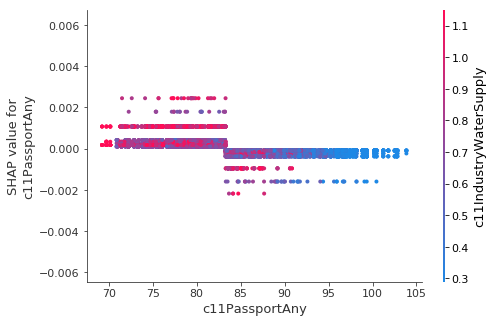

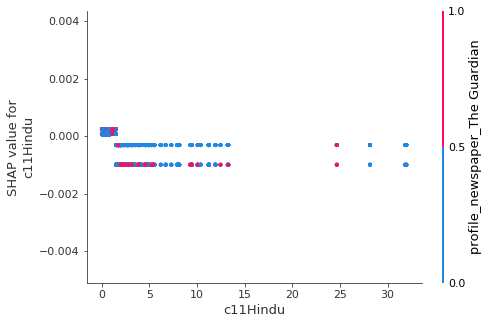

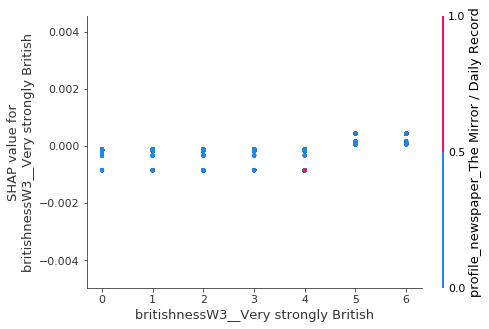

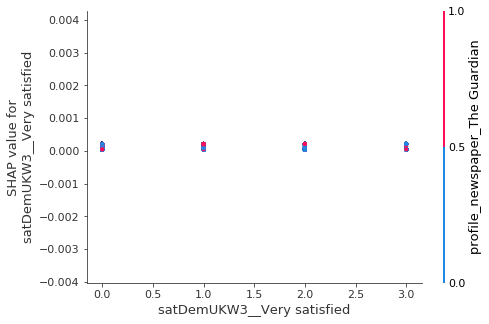

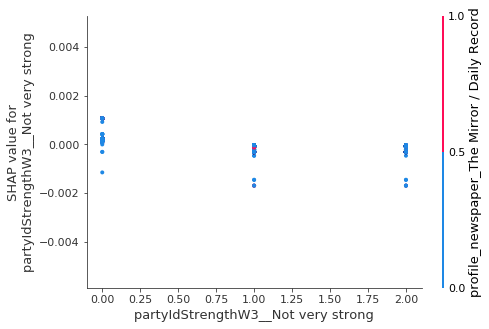

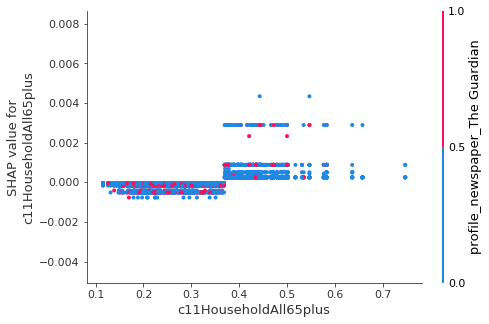

Delta_ptvLabW4 4
missing vals in sample weights: 0
[0]	validation_0-rmse:0.485001
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.468854
[2]	validation_0-rmse:0.453513
[3]	validation_0-rmse:0.438642
[4]	validation_0-rmse:0.42458
[5]	validation_0-rmse:0.411299
[6]	validation_0-rmse:0.398645
[7]	validation_0-rmse:0.386593
[8]	validation_0-rmse:0.375197
[9]	validation_0-rmse:0.364325
[10]	validation_0-rmse:0.354132
[11]	validation_0-rmse:0.344324
[12]	validation_0-rmse:0.335118
[13]	validation_0-rmse:0.326378
[14]	validation_0-rmse:0.317991
[15]	validation_0-rmse:0.310174
[16]	validation_0-rmse:0.302717
[17]	validation_0-rmse:0.295609
[18]	validation_0-rmse:0.289049
[19]	validation_0-rmse:0.28285
MSE: 0.08, MAE: 0.24, EV: 0.05, R2: -0.92


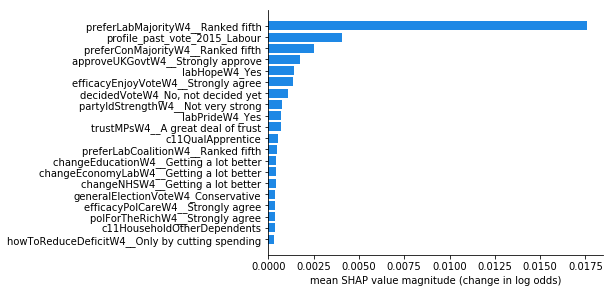

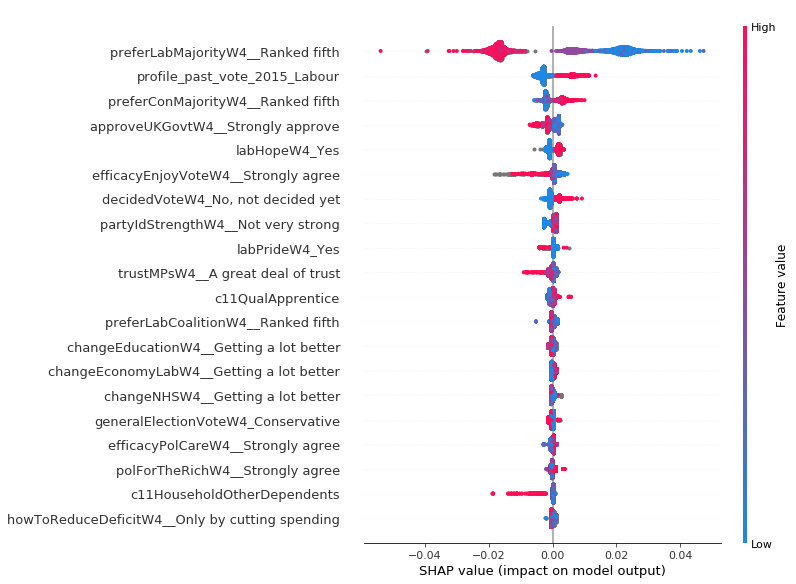

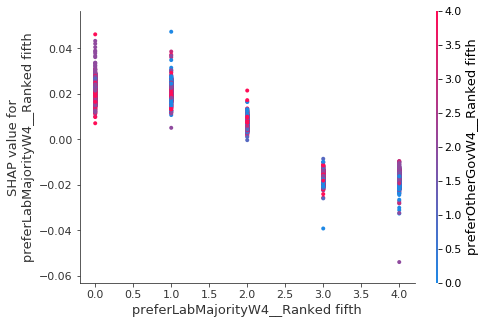

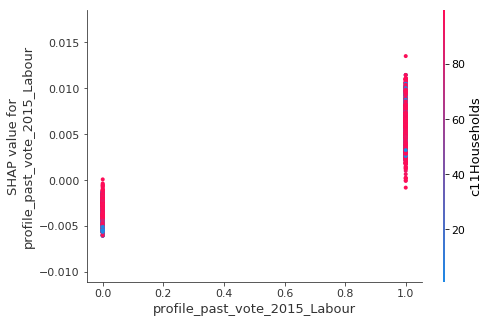

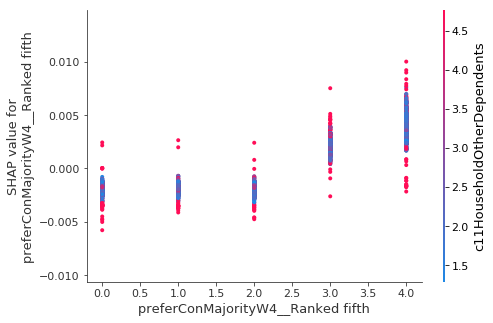

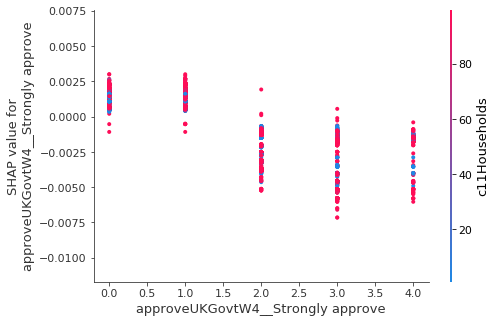

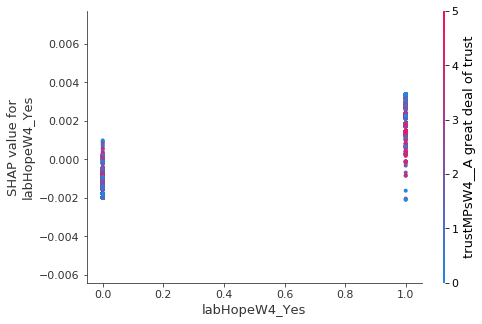

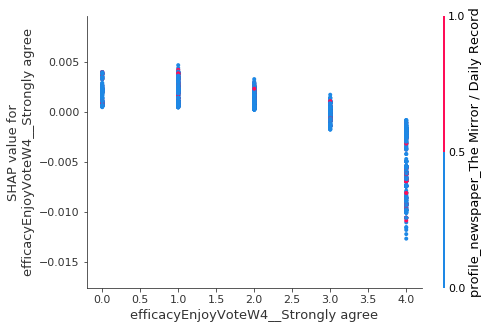

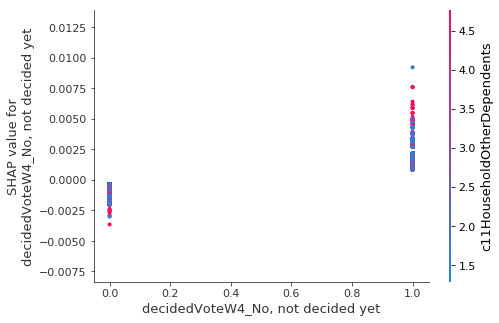

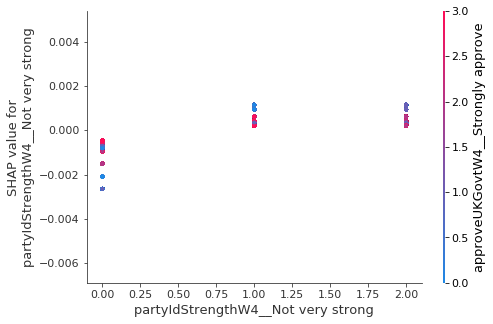

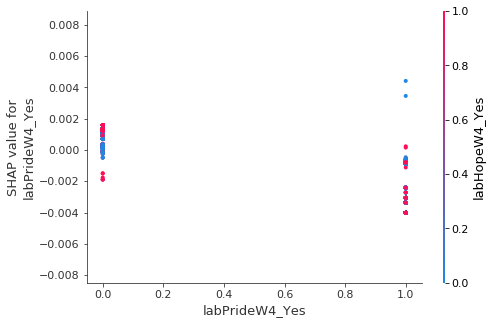

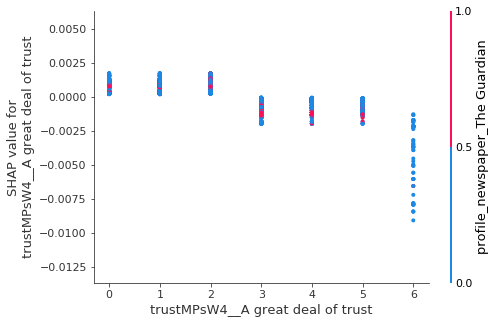

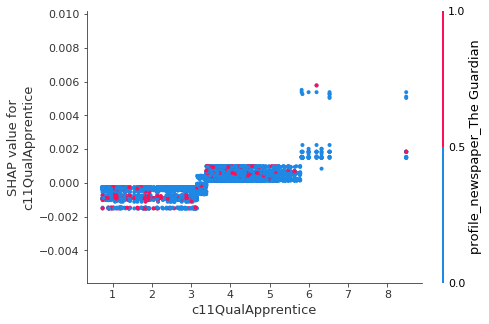

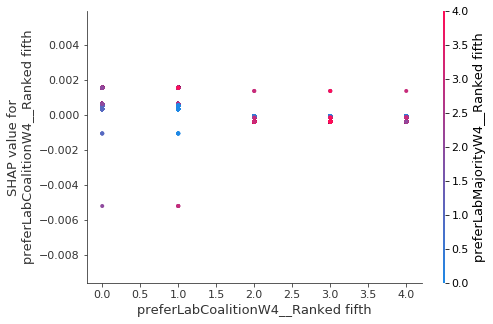

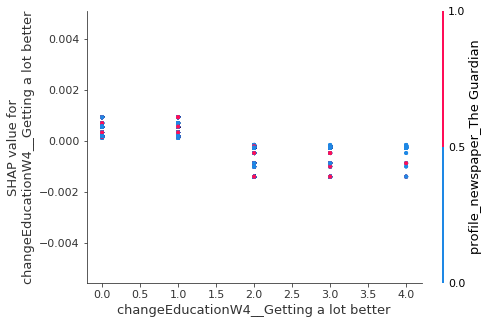

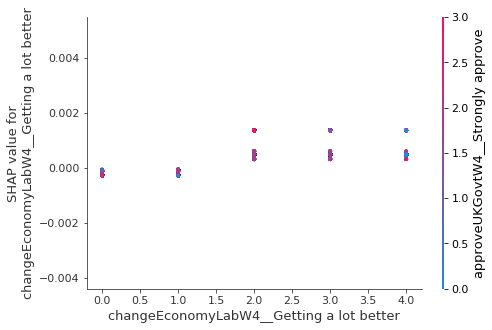

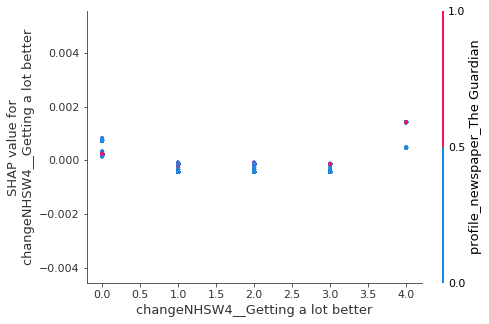

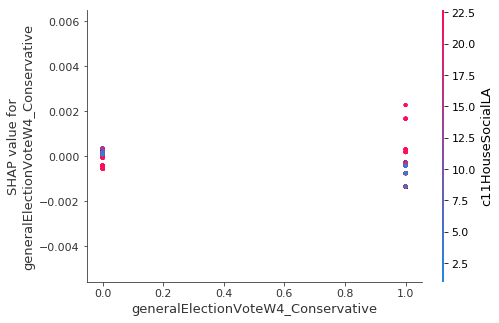

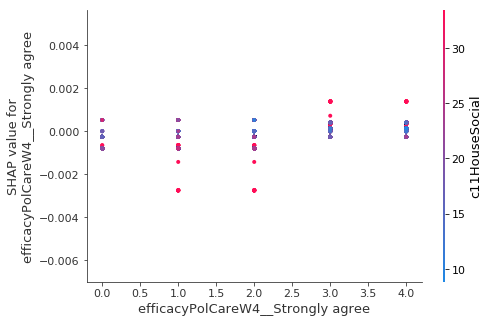

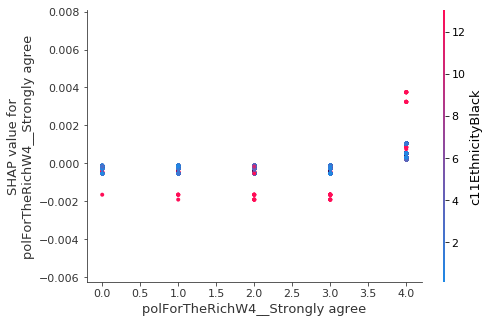

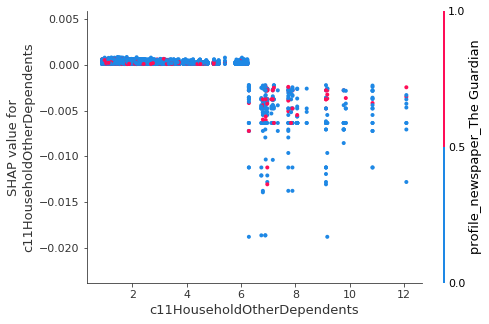

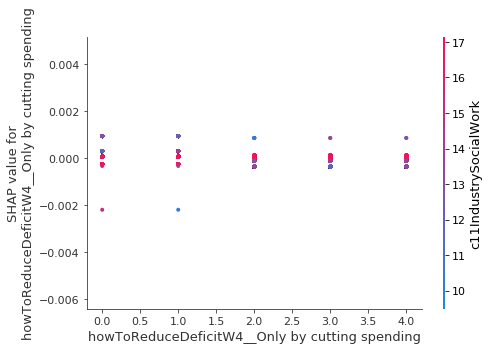

Delta_ptvLabW5 5
missing vals in sample weights: 41
[0]	validation_0-rmse:0.508879
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.491463
[2]	validation_0-rmse:0.474888
[3]	validation_0-rmse:0.459095
[4]	validation_0-rmse:0.443952
[5]	validation_0-rmse:0.429809
[6]	validation_0-rmse:0.416086
[7]	validation_0-rmse:0.403057
[8]	validation_0-rmse:0.390788
[9]	validation_0-rmse:0.379163
[10]	validation_0-rmse:0.368128
[11]	validation_0-rmse:0.357616
[12]	validation_0-rmse:0.347674
[13]	validation_0-rmse:0.338121
[14]	validation_0-rmse:0.329159
[15]	validation_0-rmse:0.320669
[16]	validation_0-rmse:0.312783
[17]	validation_0-rmse:0.305276
[18]	validation_0-rmse:0.298187
[19]	validation_0-rmse:0.291491
MSE: 0.08, MAE: 0.25, EV: 0.01, R2: -1.12


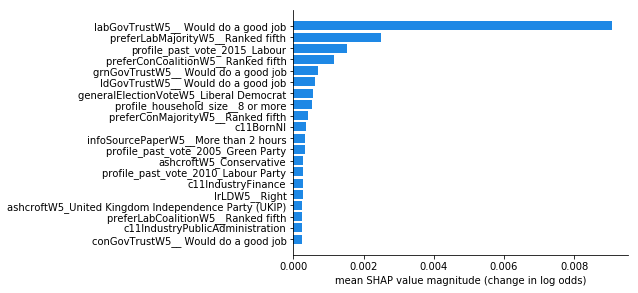

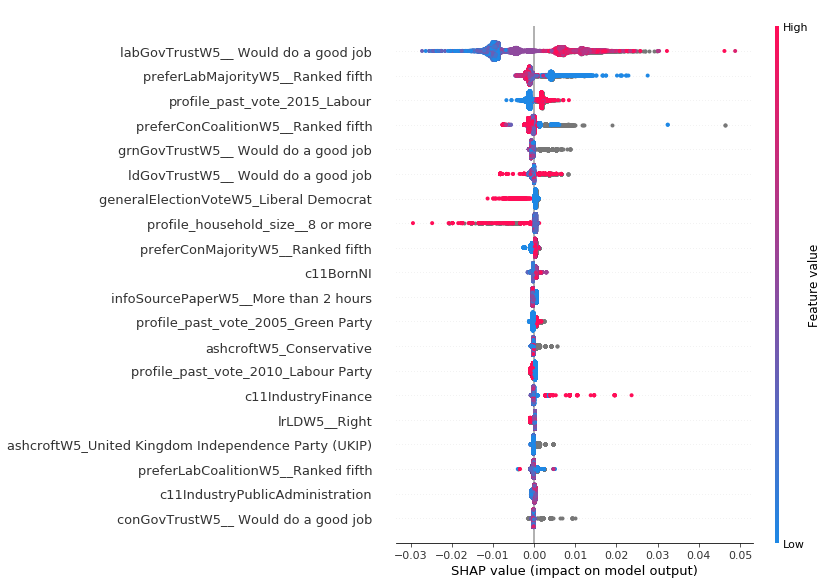

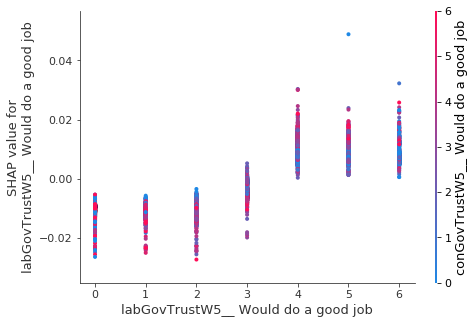

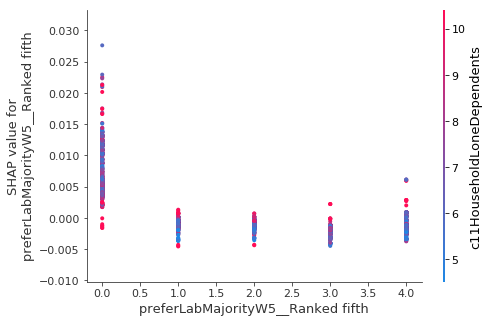

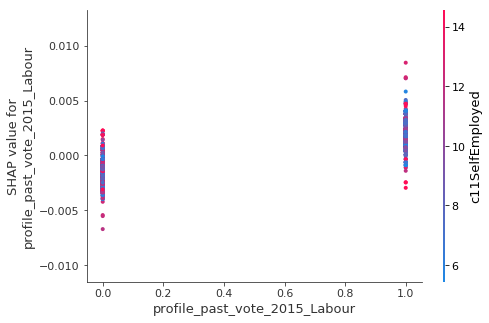

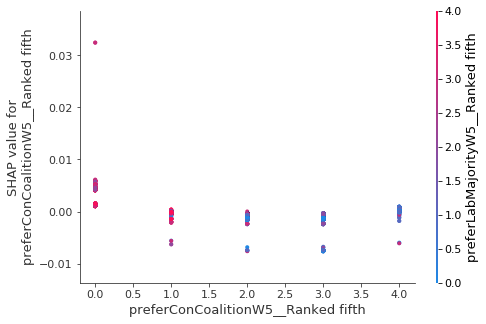

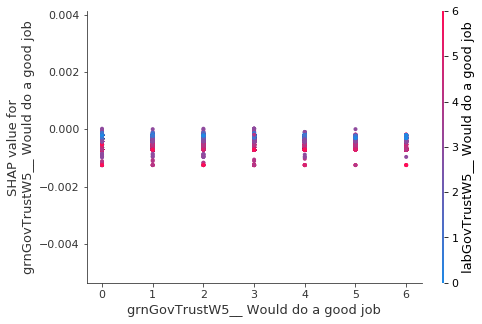

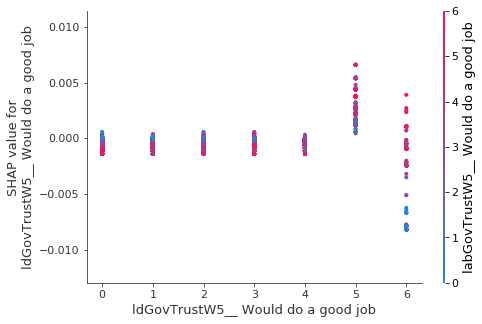

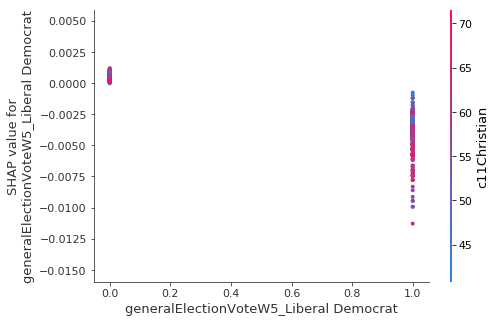

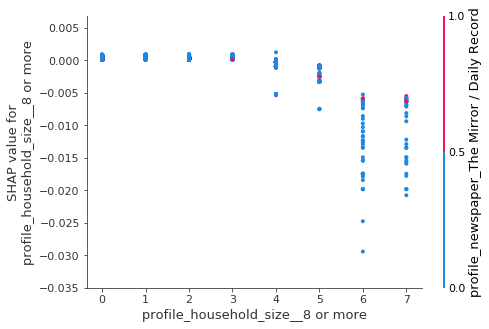

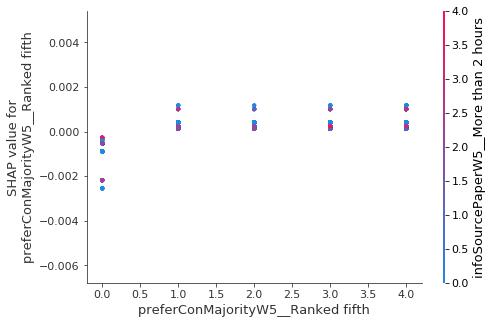

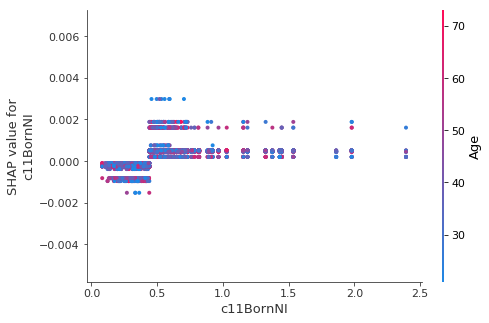

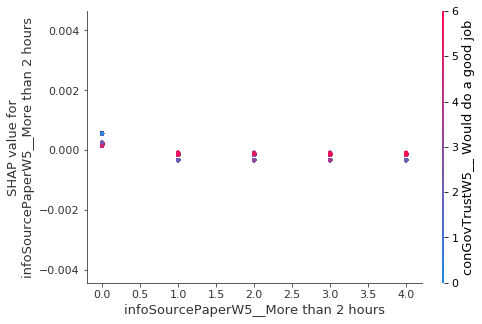

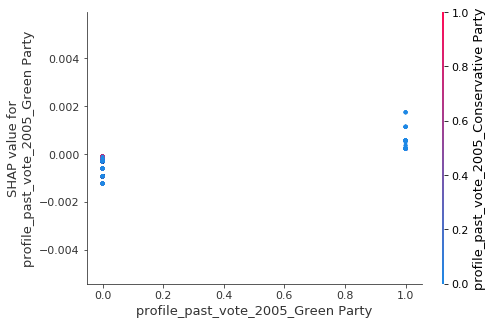

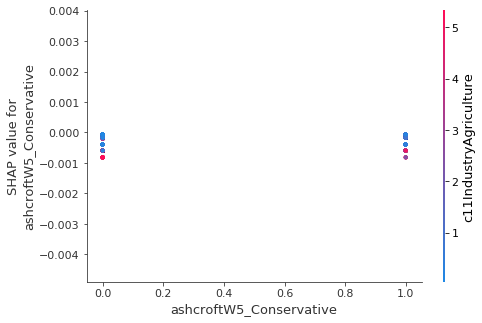

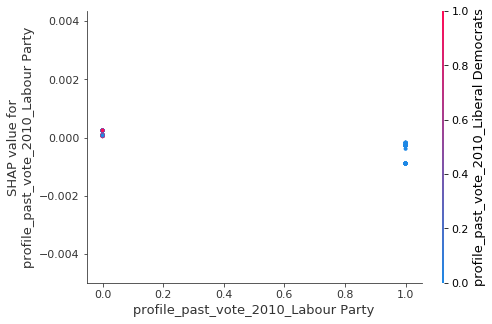

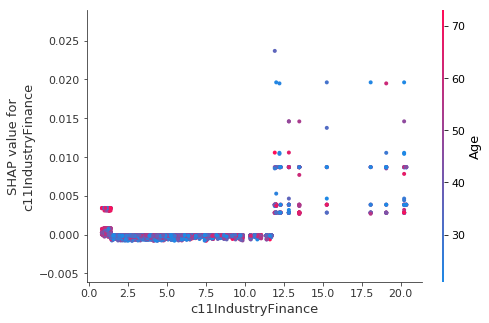

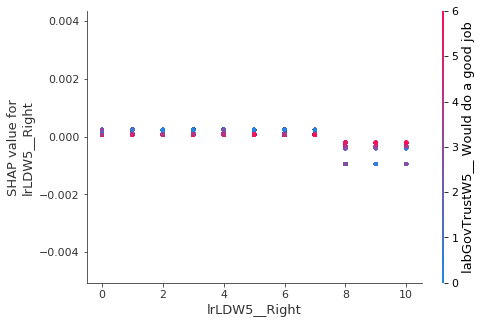

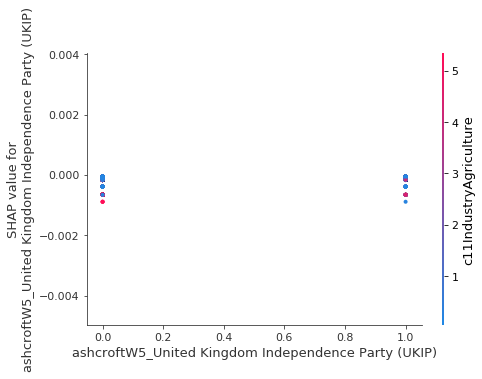

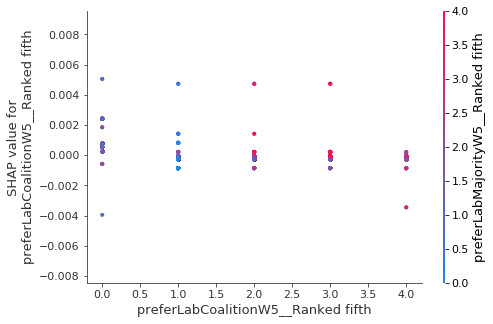

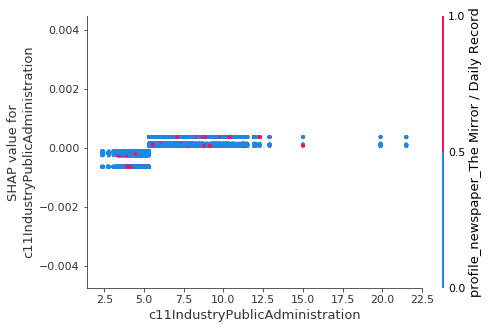

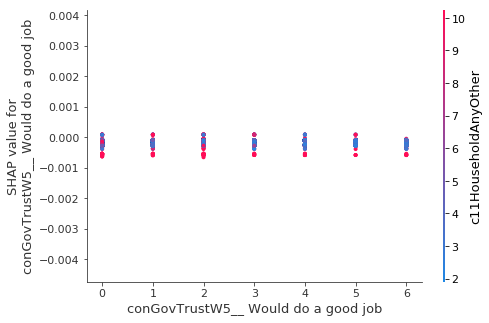

Delta_ptvLabW6 6
missing vals in sample weights: 34
[0]	validation_0-rmse:0.518033
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.500567
[2]	validation_0-rmse:0.483864
[3]	validation_0-rmse:0.46805
[4]	validation_0-rmse:0.452913
[5]	validation_0-rmse:0.438532
[6]	validation_0-rmse:0.424826
[7]	validation_0-rmse:0.411765
[8]	validation_0-rmse:0.399263
[9]	validation_0-rmse:0.387436
[10]	validation_0-rmse:0.376062
[11]	validation_0-rmse:0.365492
[12]	validation_0-rmse:0.355231
[13]	validation_0-rmse:0.345685
[14]	validation_0-rmse:0.336629
[15]	validation_0-rmse:0.328043
[16]	validation_0-rmse:0.319902
[17]	validation_0-rmse:0.312214
[18]	validation_0-rmse:0.304988
[19]	validation_0-rmse:0.298204
MSE: 0.09, MAE: 0.25, EV: 0.00, R2: -1.21


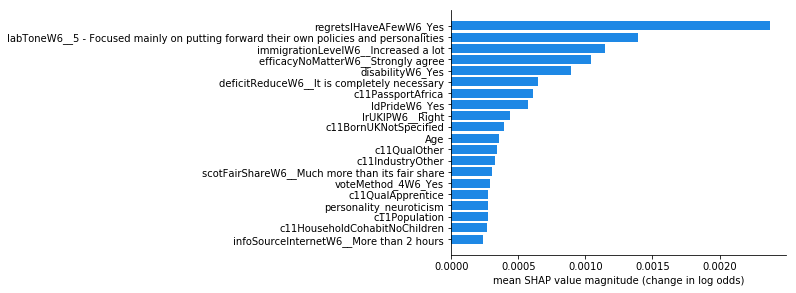

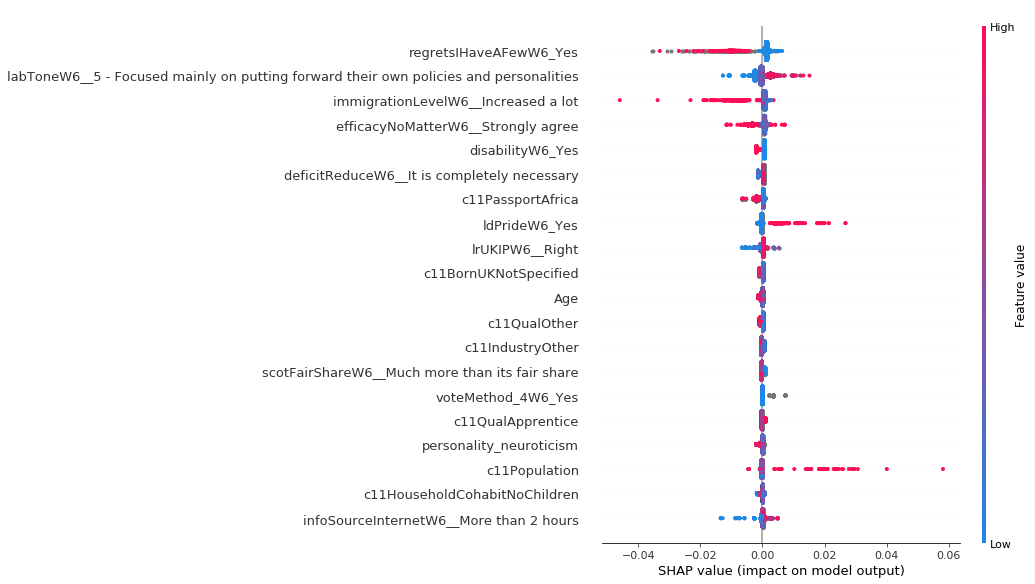

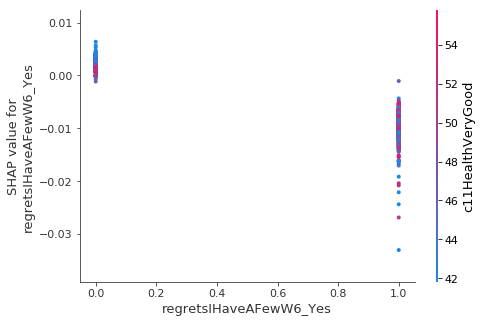

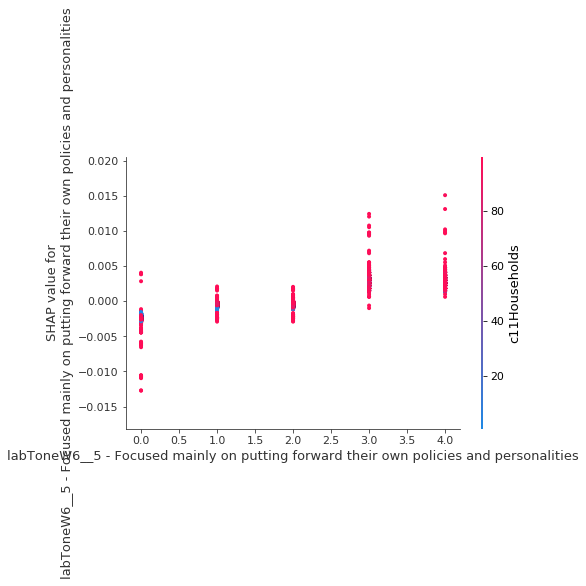

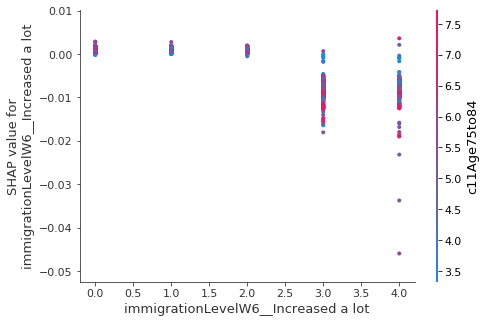

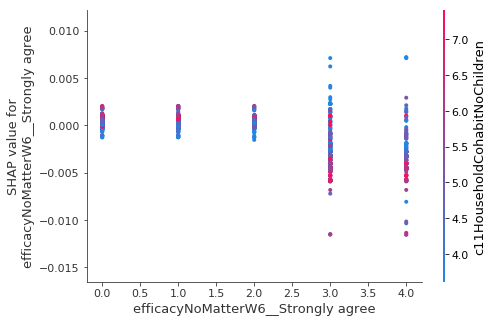

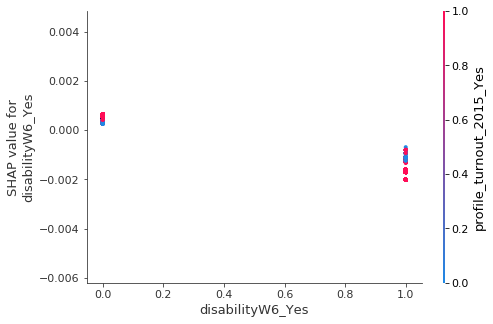

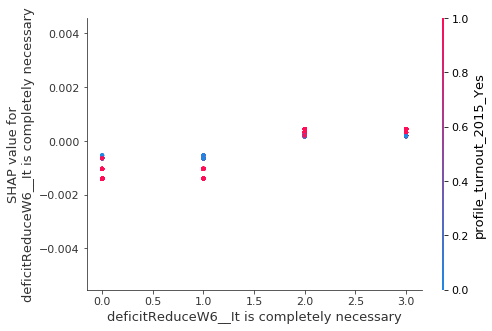

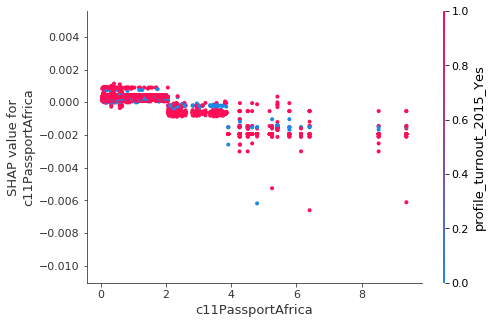

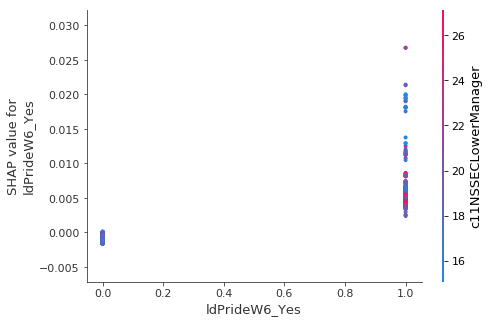

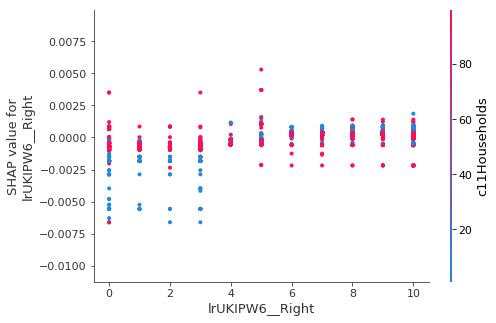

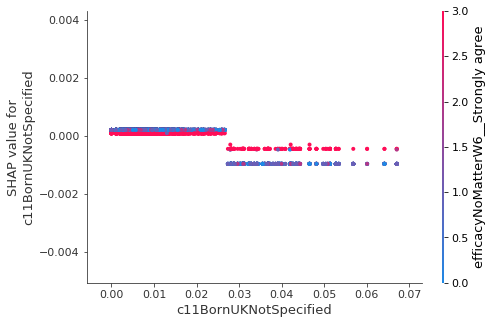

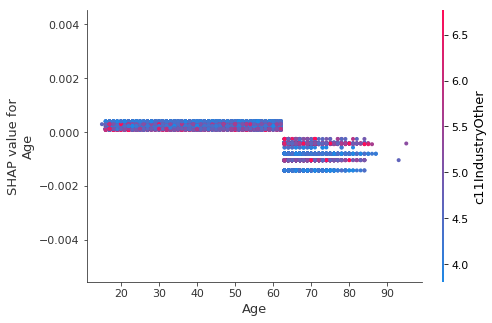

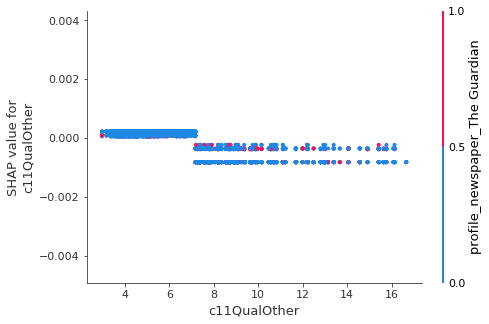

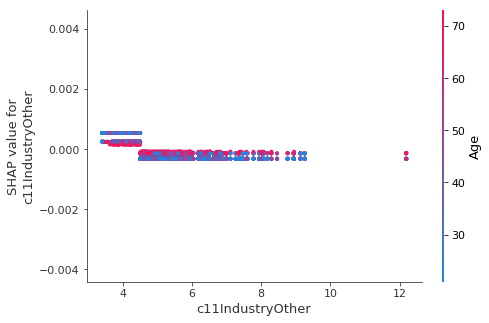

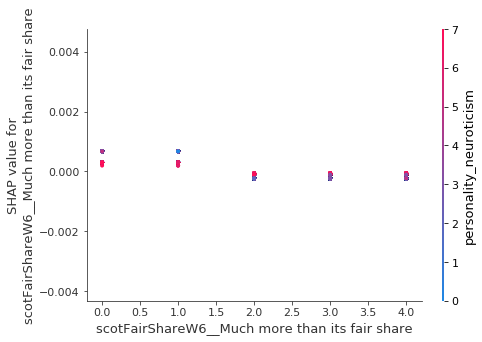

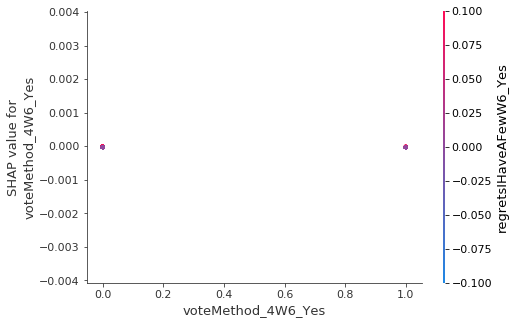

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


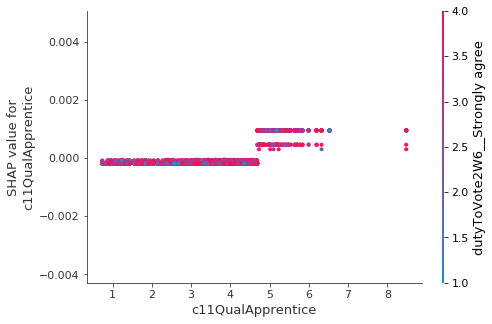

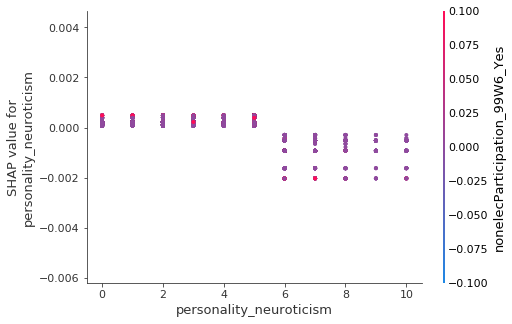

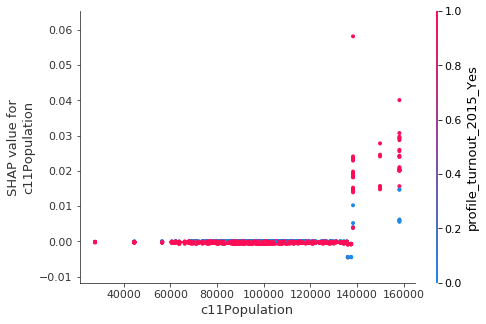

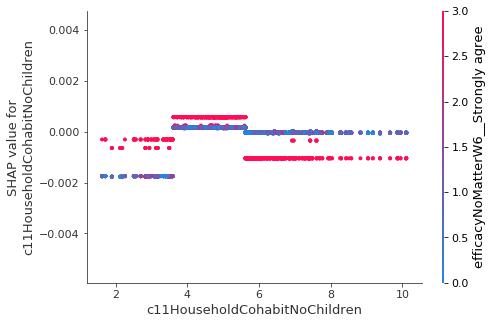

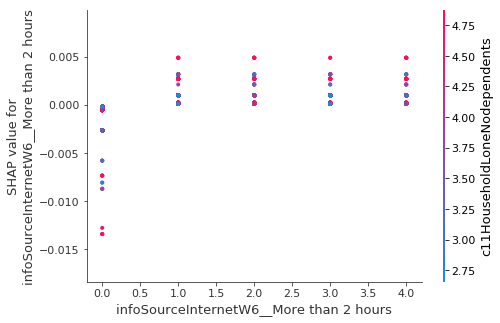

Delta_ptvLabW7 7
missing vals in sample weights: 0
[0]	validation_0-rmse:0.553772
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.535427
[2]	validation_0-rmse:0.517533
[3]	validation_0-rmse:0.500663
[4]	validation_0-rmse:0.484593
[5]	validation_0-rmse:0.469333
[6]	validation_0-rmse:0.454705
[7]	validation_0-rmse:0.441072
[8]	validation_0-rmse:0.428083
[9]	validation_0-rmse:0.41573
[10]	validation_0-rmse:0.404079
[11]	validation_0-rmse:0.39279
[12]	validation_0-rmse:0.382086
[13]	validation_0-rmse:0.372081
[14]	validation_0-rmse:0.362591
[15]	validation_0-rmse:0.35375
[16]	validation_0-rmse:0.345405
[17]	validation_0-rmse:0.337531
[18]	validation_0-rmse:0.329924
[19]	validation_0-rmse:0.322902
MSE: 0.10, MAE: 0.27, EV: 0.05, R2: -0.91


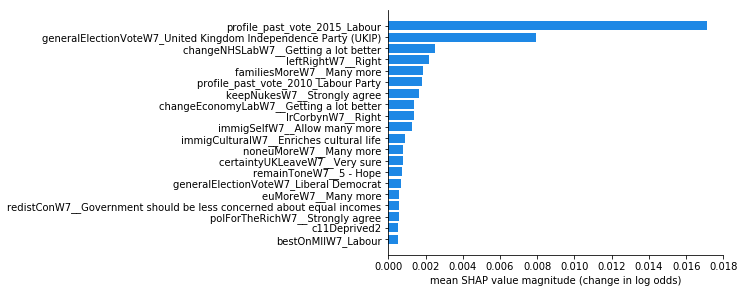

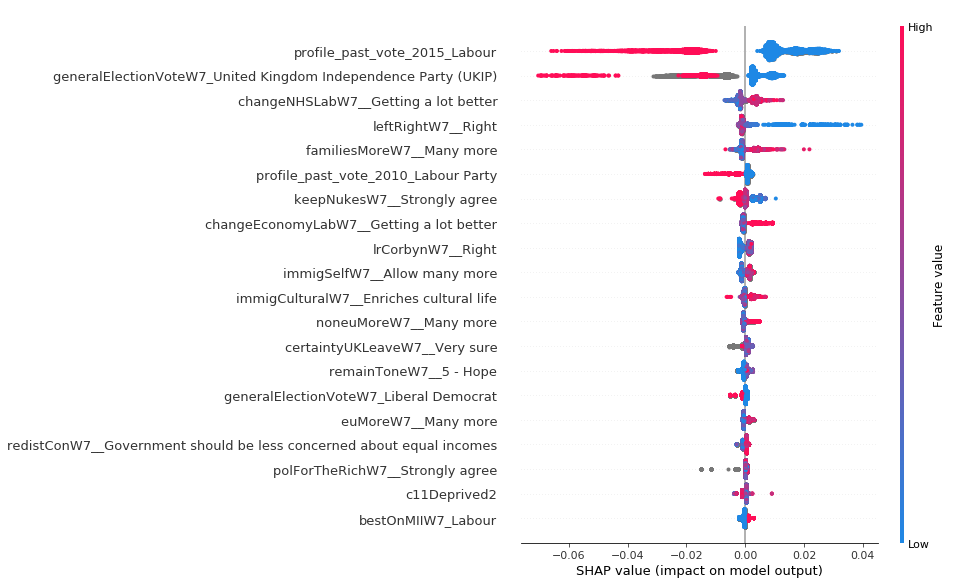

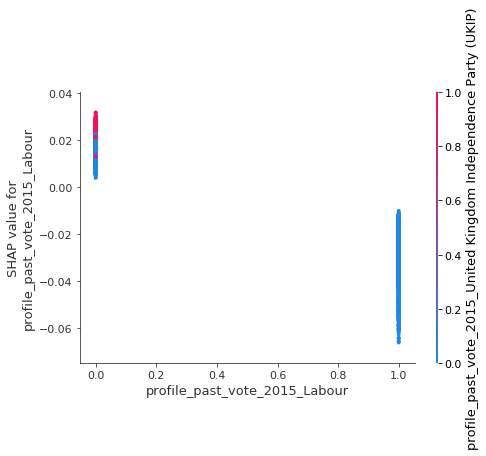

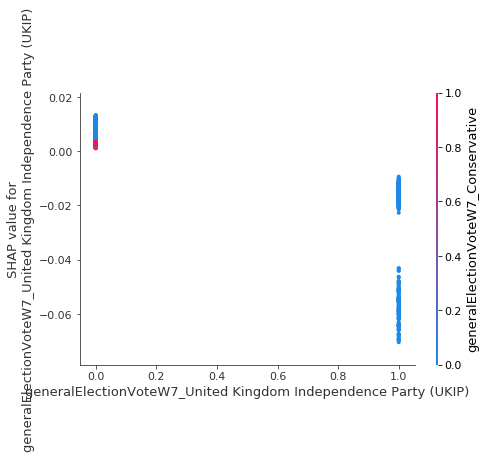

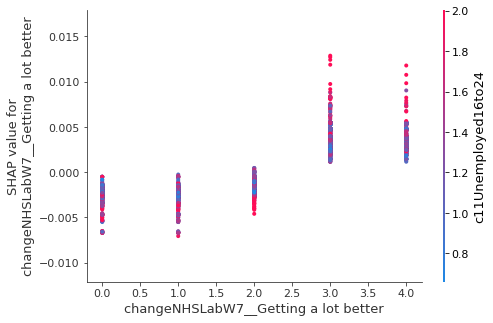

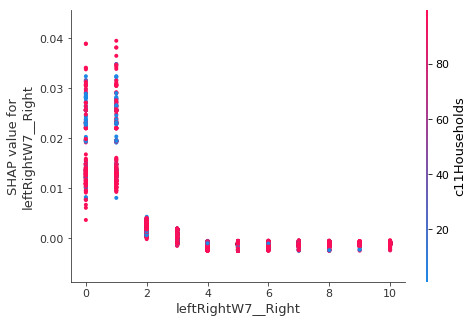

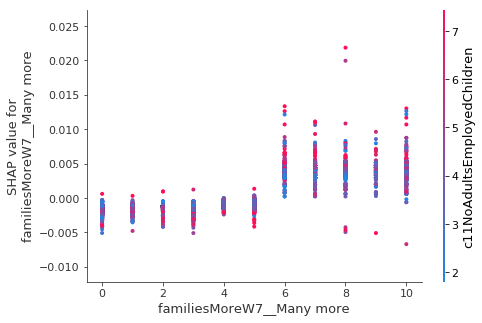

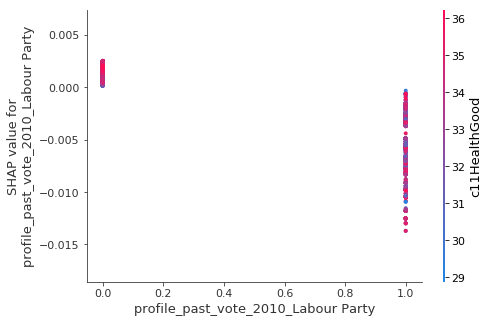

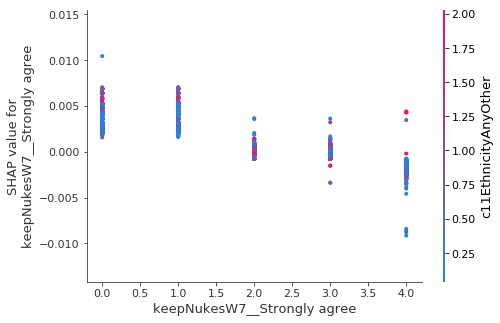

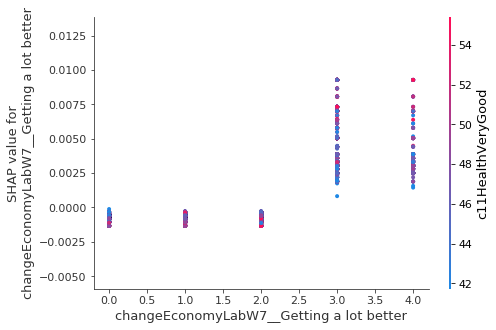

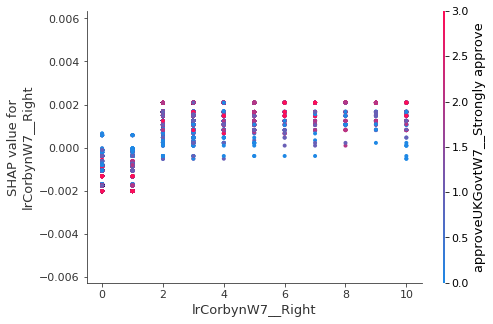

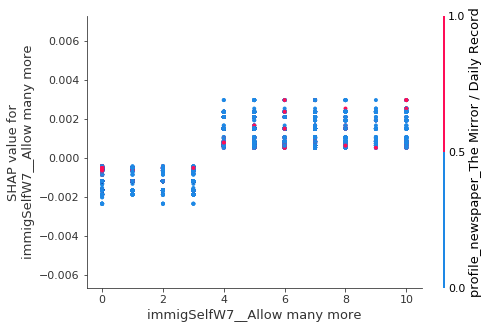

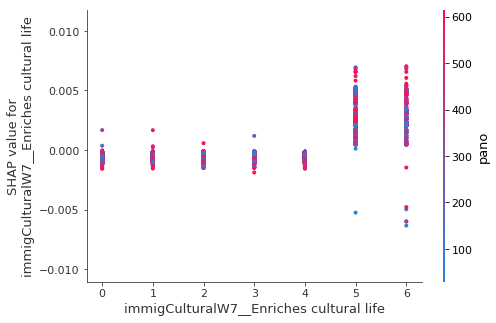

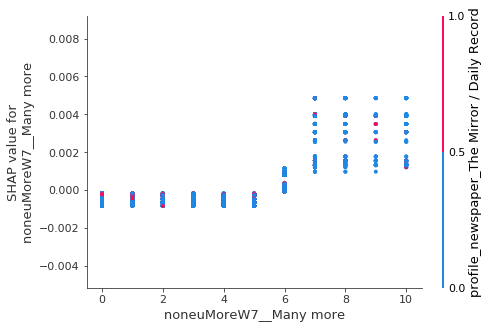

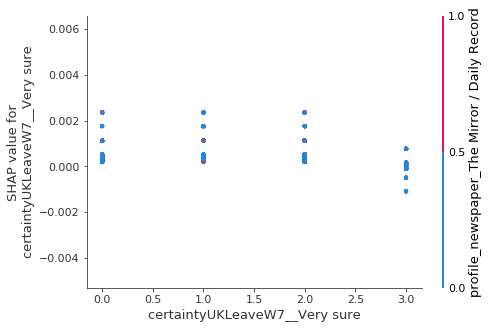

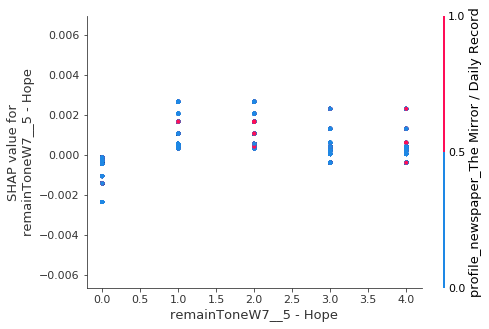

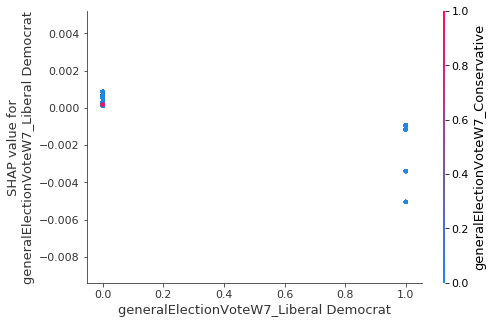

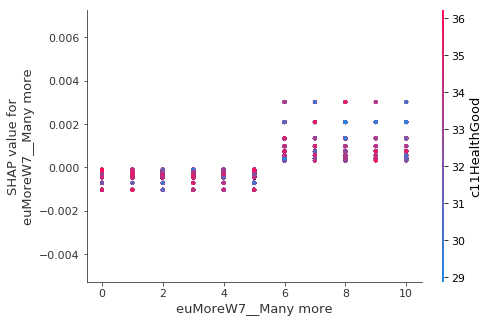

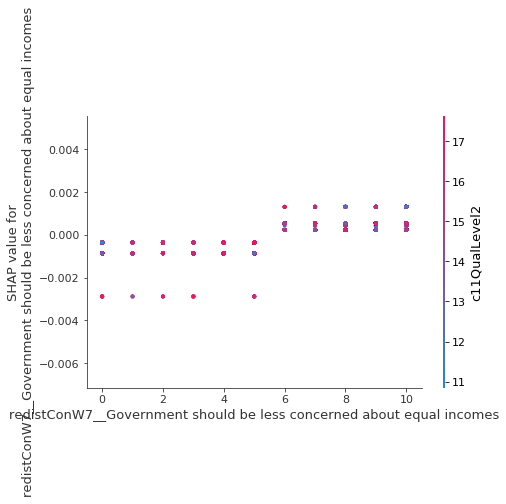

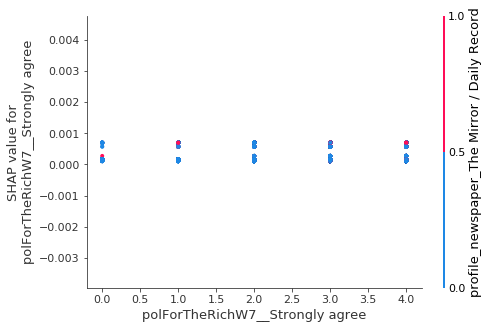

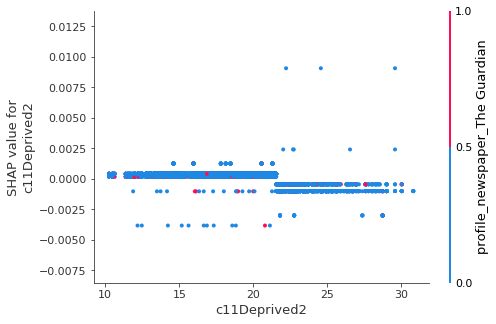

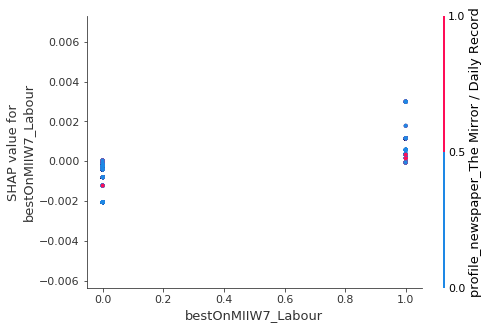

Delta_ptvLabW9 9
missing vals in sample weights: 0
[0]	validation_0-rmse:0.540809
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.522153
[2]	validation_0-rmse:0.504471
[3]	validation_0-rmse:0.487629
[4]	validation_0-rmse:0.471723
[5]	validation_0-rmse:0.456459
[6]	validation_0-rmse:0.44186
[7]	validation_0-rmse:0.427829
[8]	validation_0-rmse:0.414639
[9]	validation_0-rmse:0.401968
[10]	validation_0-rmse:0.390117
[11]	validation_0-rmse:0.378816
[12]	validation_0-rmse:0.368062
[13]	validation_0-rmse:0.35816
[14]	validation_0-rmse:0.348582
[15]	validation_0-rmse:0.339494
[16]	validation_0-rmse:0.330945
[17]	validation_0-rmse:0.322852
[18]	validation_0-rmse:0.315316
[19]	validation_0-rmse:0.307968
MSE: 0.09, MAE: 0.26, EV: -0.00, R2: -1.21


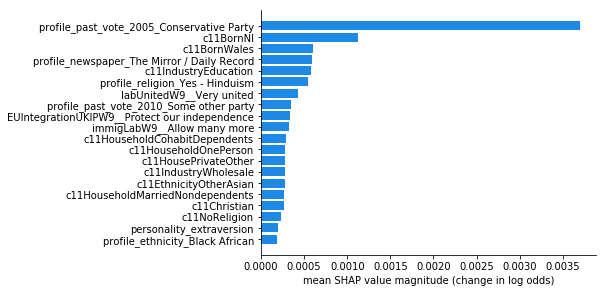

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


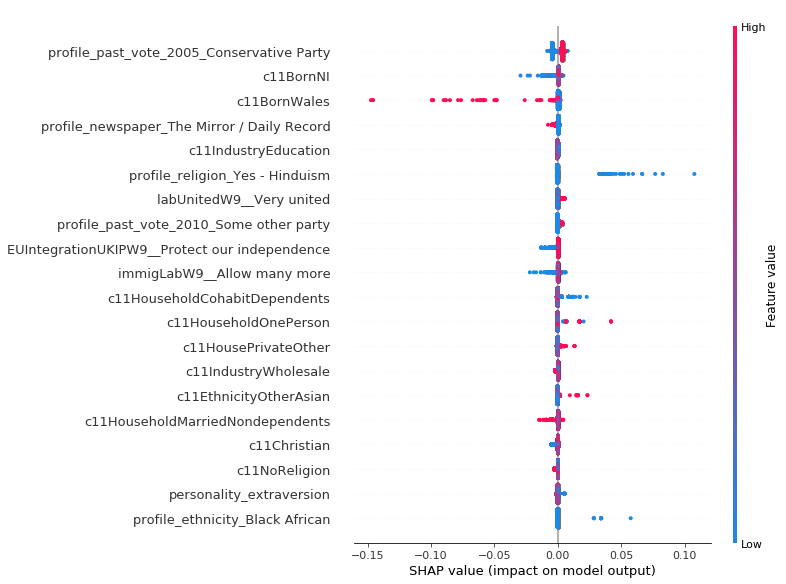

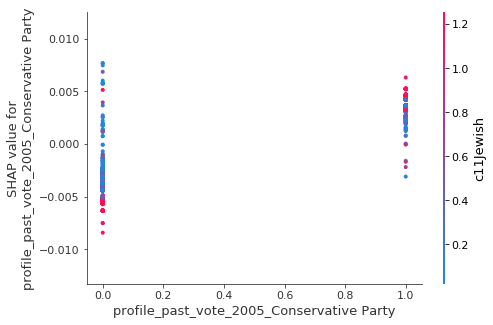

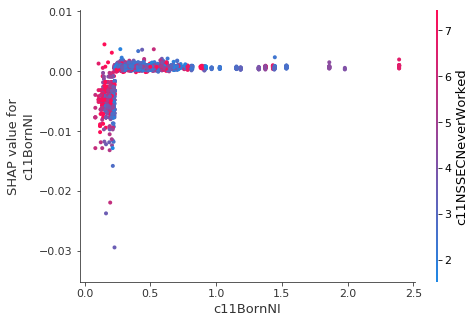

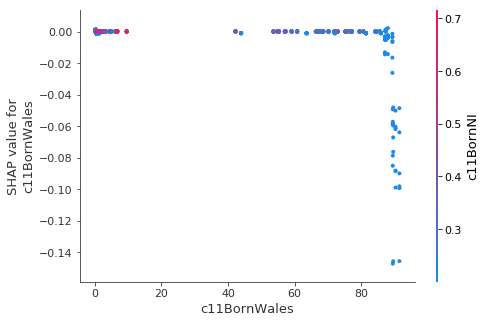

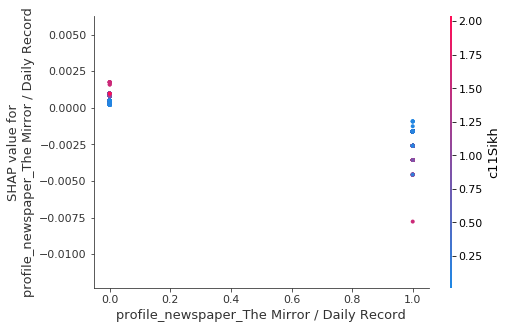

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


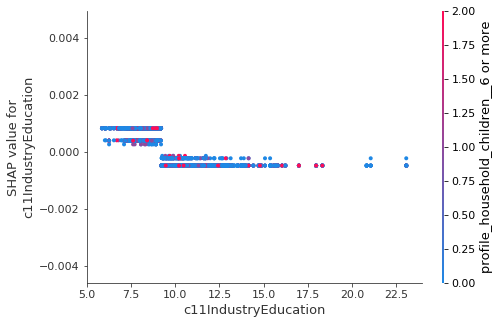

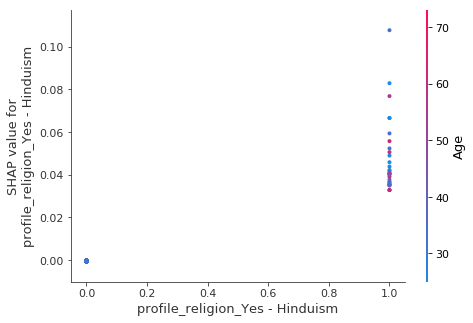

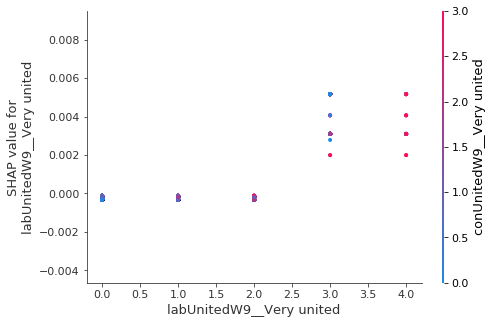

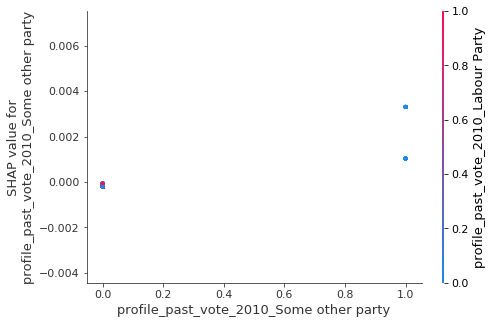

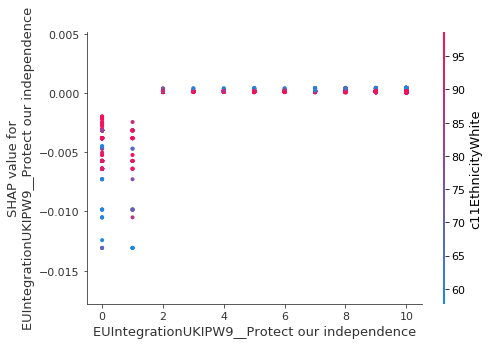

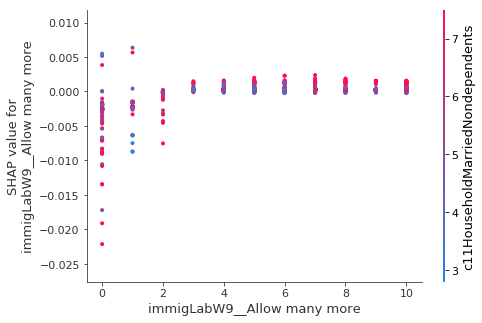

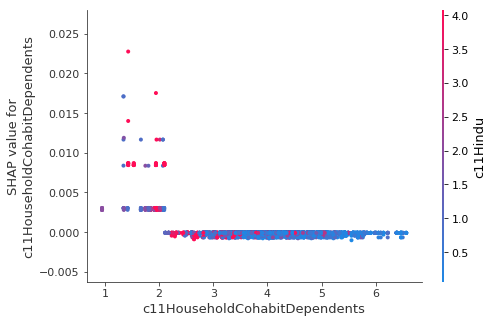

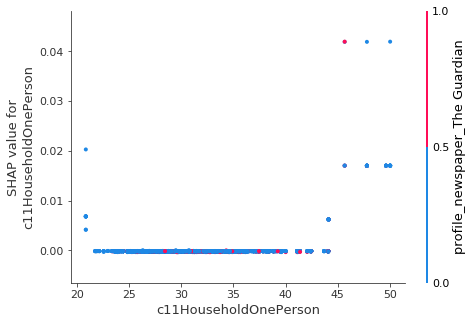

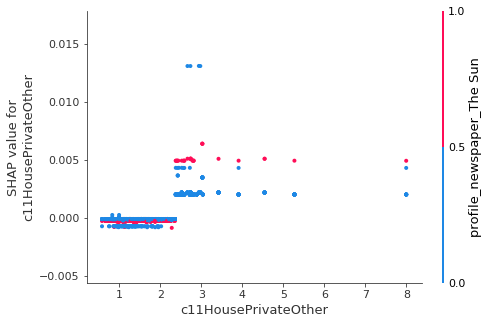

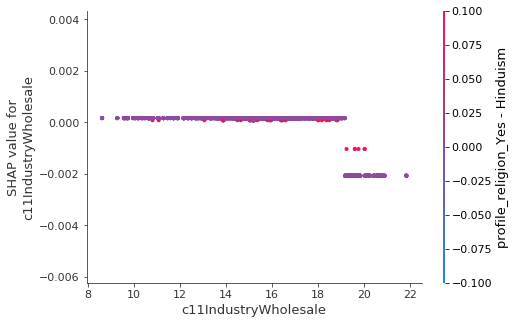

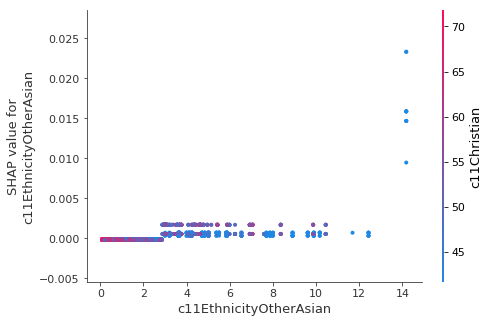

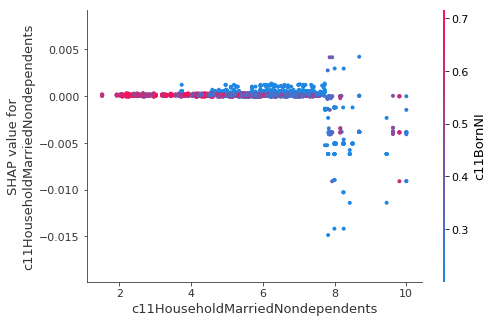

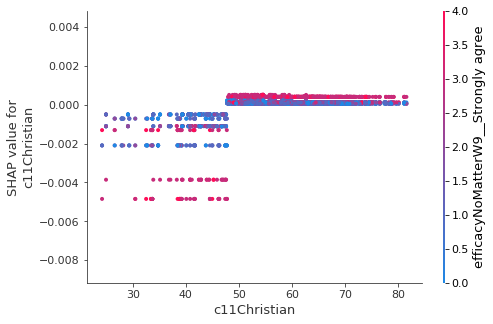

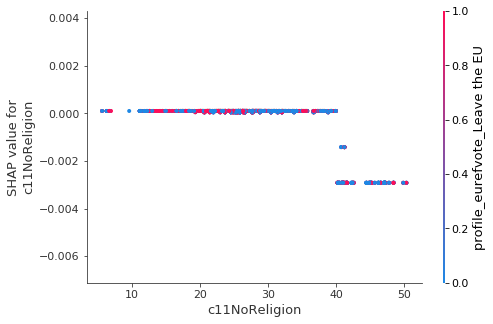

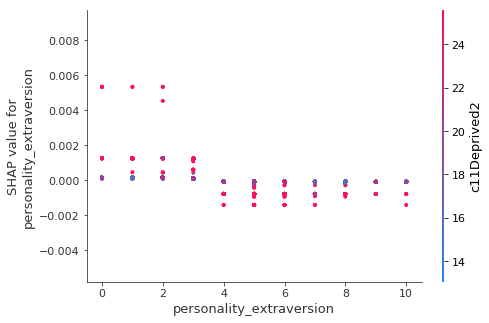

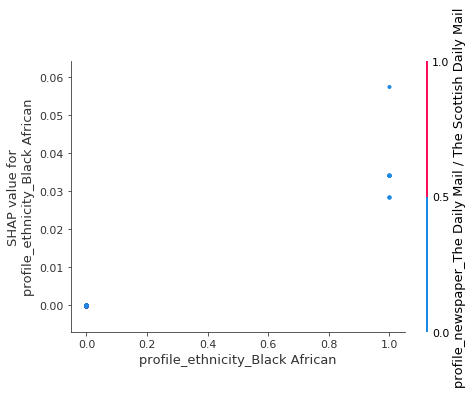

Delta_ptvLabW10 10
missing vals in sample weights: 0
[0]	validation_0-rmse:0.547116
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.52899
[2]	validation_0-rmse:0.511655
[3]	validation_0-rmse:0.495061
[4]	validation_0-rmse:0.479188
[5]	validation_0-rmse:0.464149
[6]	validation_0-rmse:0.449784
[7]	validation_0-rmse:0.43625
[8]	validation_0-rmse:0.423394
[9]	validation_0-rmse:0.411088
[10]	validation_0-rmse:0.399387
[11]	validation_0-rmse:0.388378
[12]	validation_0-rmse:0.377923
[13]	validation_0-rmse:0.368014
[14]	validation_0-rmse:0.3585
[15]	validation_0-rmse:0.349655
[16]	validation_0-rmse:0.341338
[17]	validation_0-rmse:0.333336
[18]	validation_0-rmse:0.325886
[19]	validation_0-rmse:0.318882
MSE: 0.10, MAE: 0.27, EV: 0.01, R2: -1.11


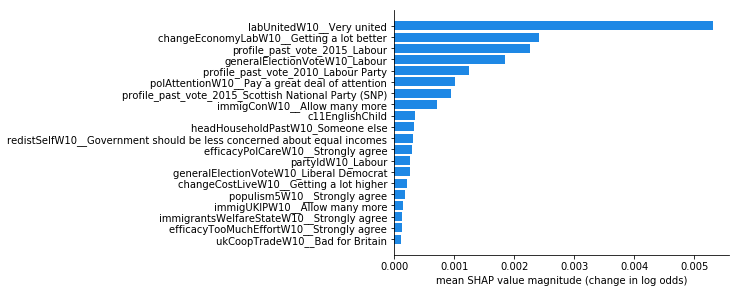

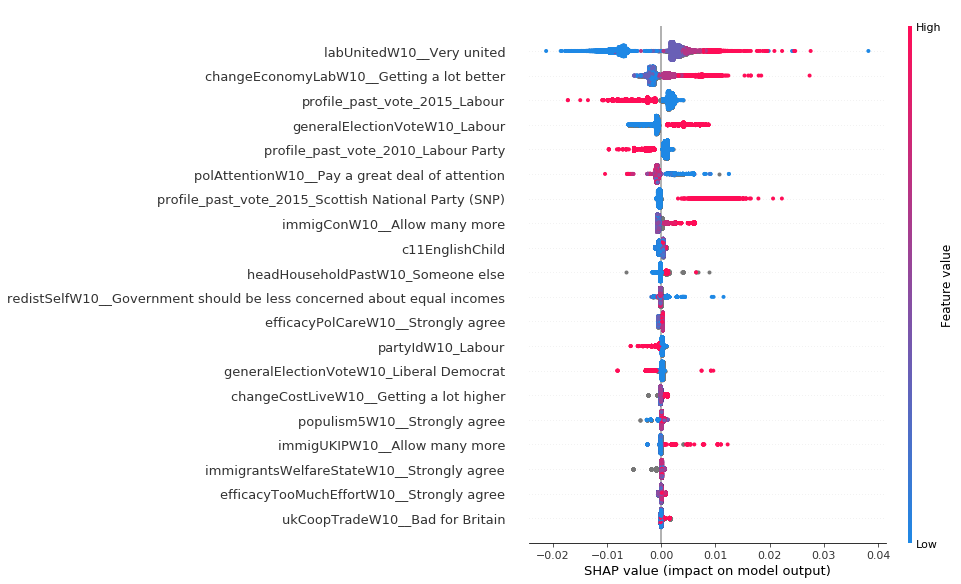

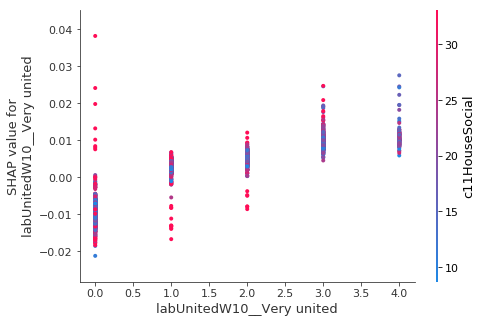

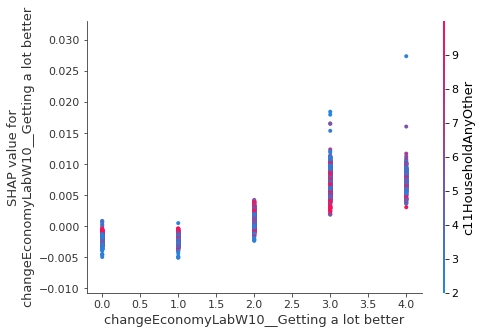

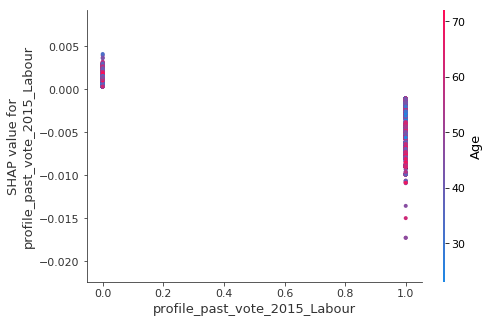

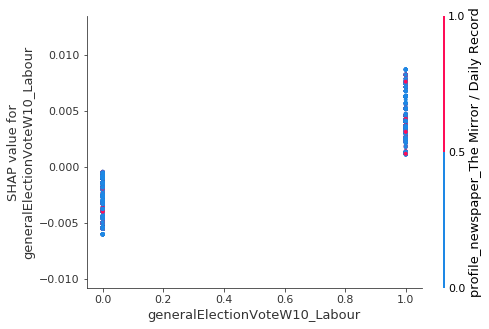

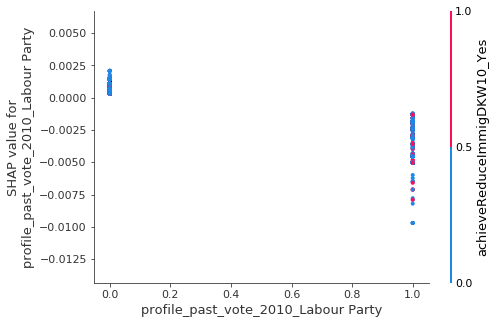

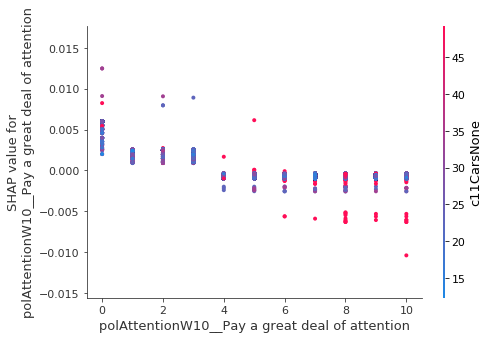

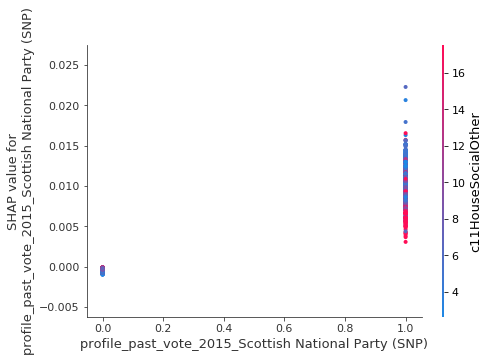

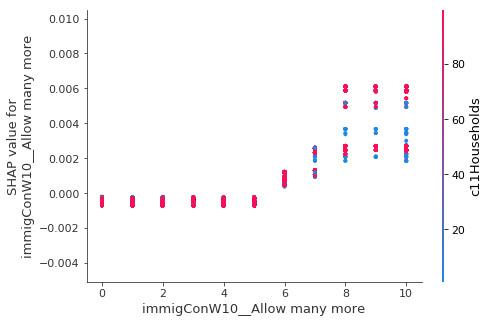

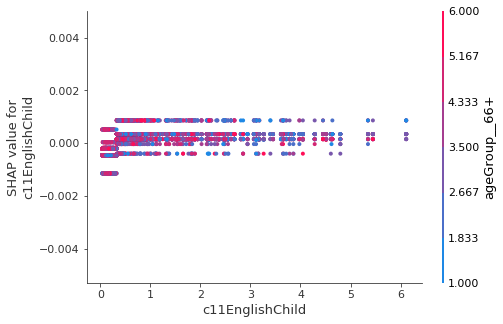

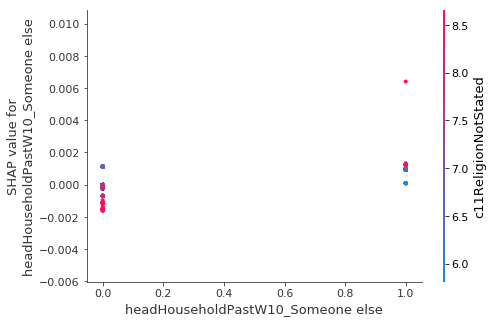

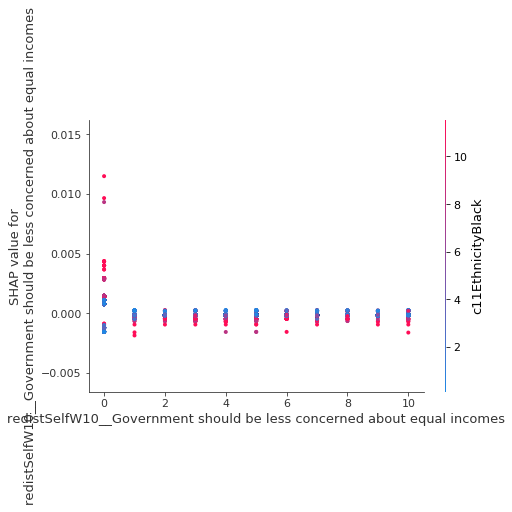

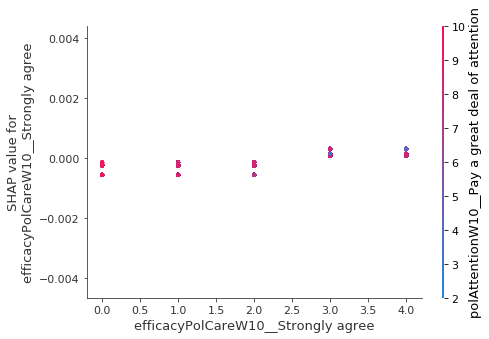

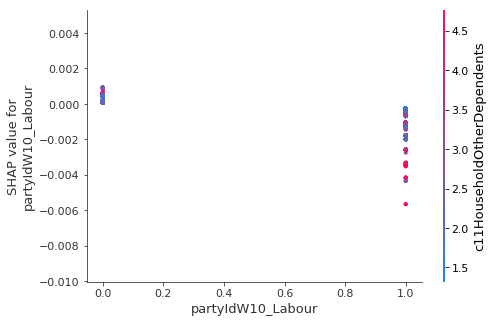

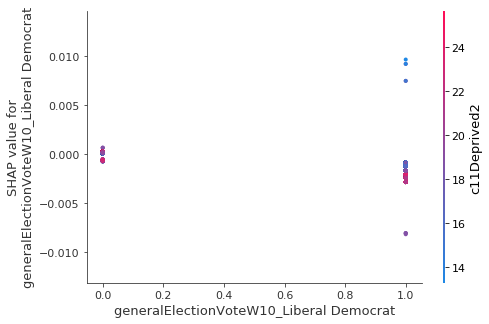

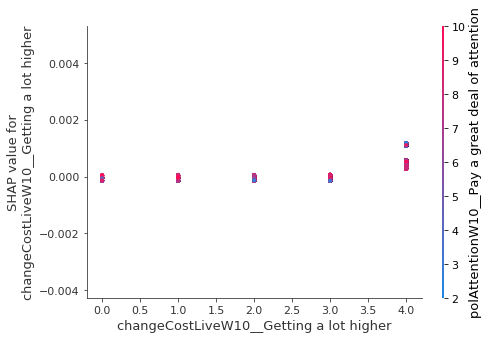

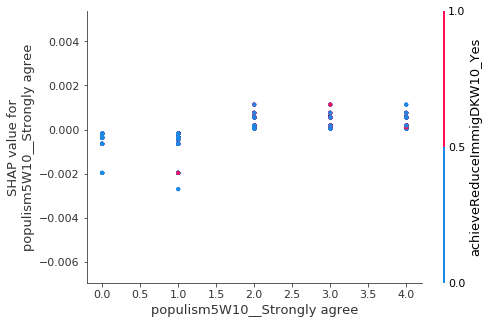

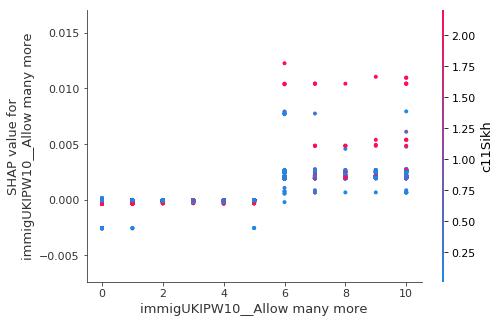

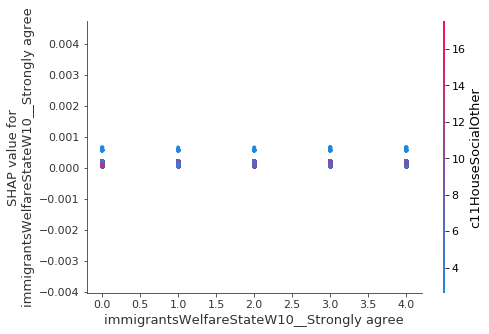

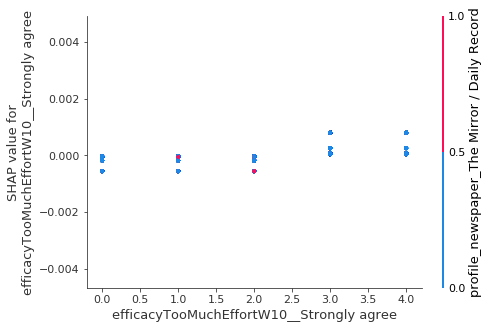

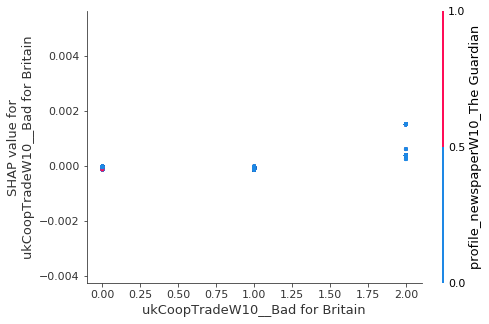

Delta_ptvLabW11 11
missing vals in sample weights: 0
[0]	validation_0-rmse:0.511029
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.49425
[2]	validation_0-rmse:0.478401
[3]	validation_0-rmse:0.463216
[4]	validation_0-rmse:0.448864
[5]	validation_0-rmse:0.435059
[6]	validation_0-rmse:0.422092
[7]	validation_0-rmse:0.409676
[8]	validation_0-rmse:0.397826
[9]	validation_0-rmse:0.386718
[10]	validation_0-rmse:0.376118
[11]	validation_0-rmse:0.366099
[12]	validation_0-rmse:0.356515
[13]	validation_0-rmse:0.347577
[14]	validation_0-rmse:0.339067
[15]	validation_0-rmse:0.331029
[16]	validation_0-rmse:0.323415
[17]	validation_0-rmse:0.316197
[18]	validation_0-rmse:0.309486
[19]	validation_0-rmse:0.303085
MSE: 0.09, MAE: 0.26, EV: 0.01, R2: -0.99


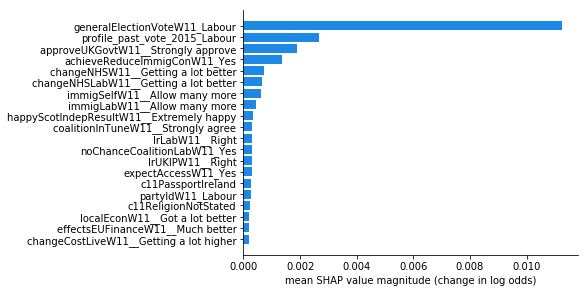

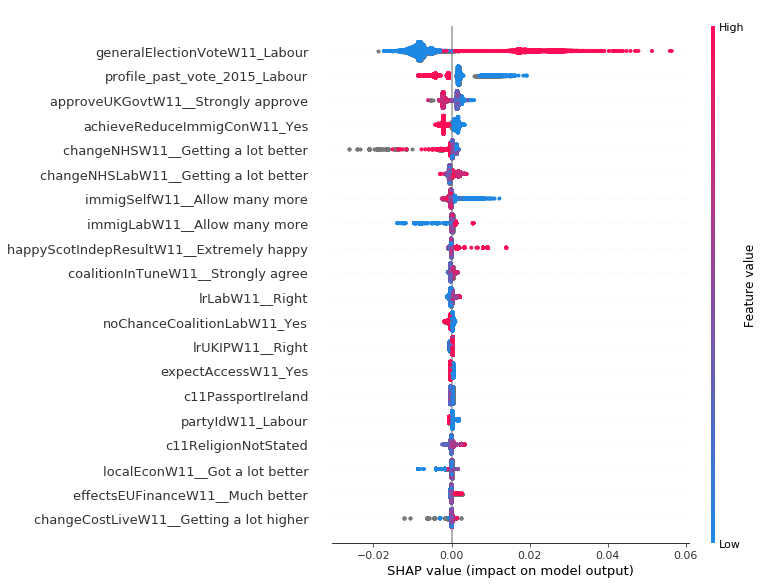

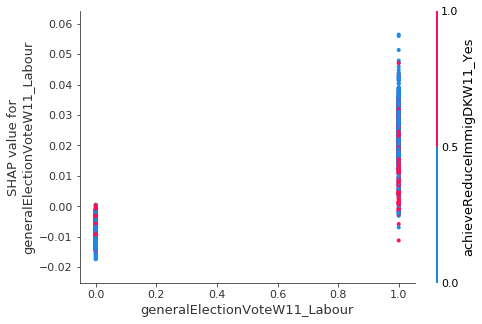

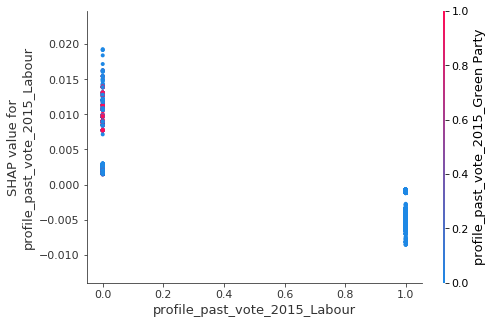

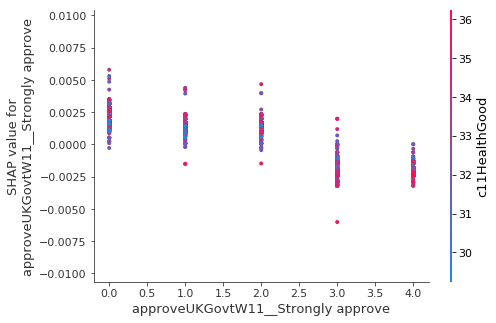

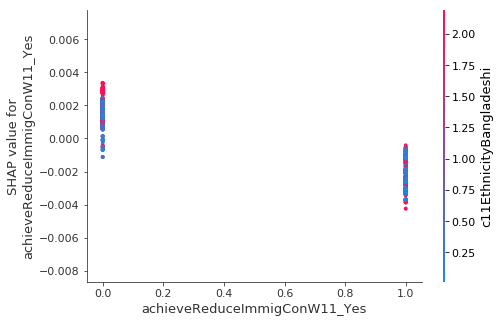

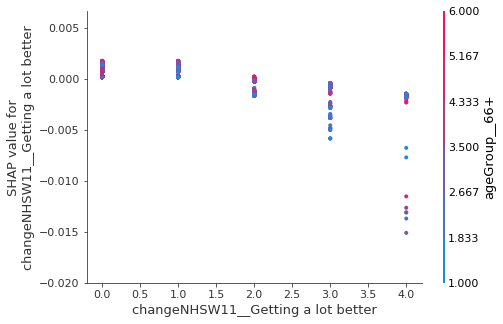

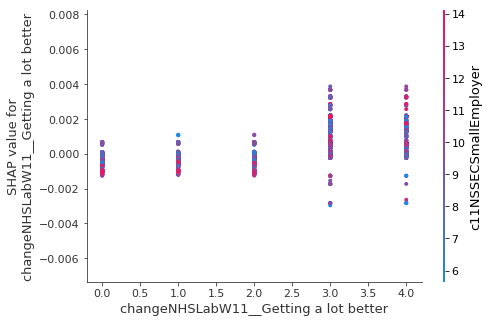

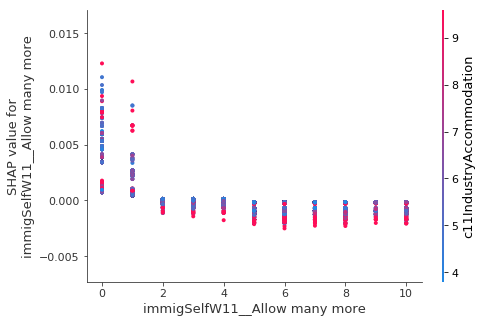

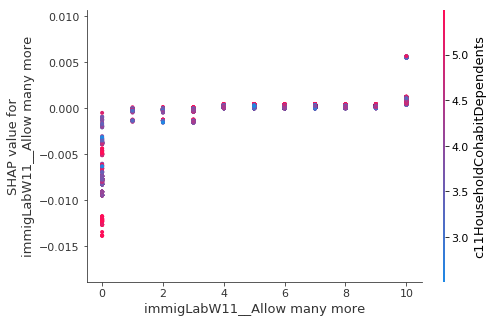

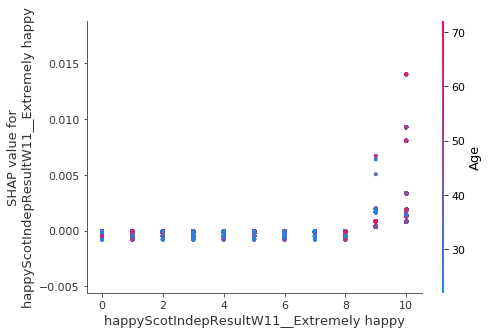

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


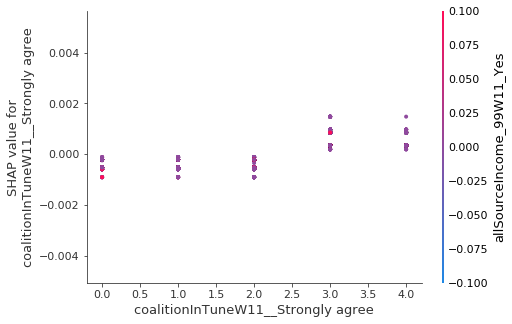

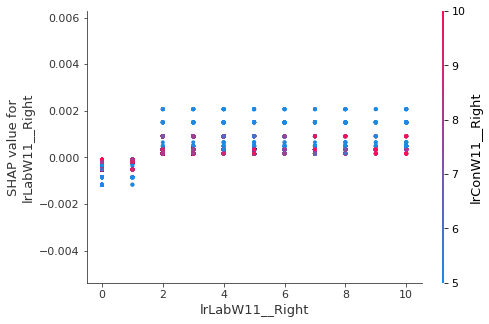

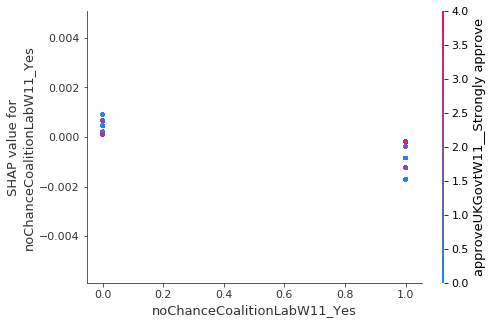

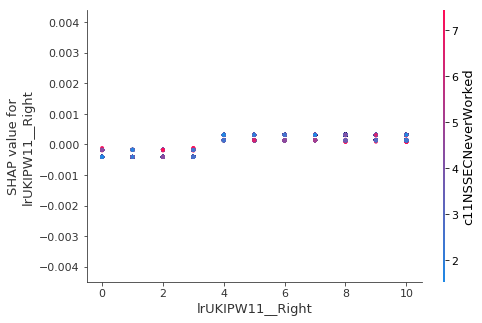

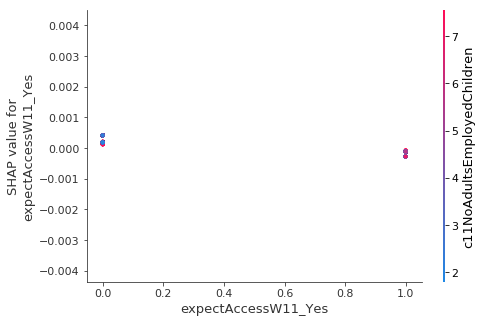

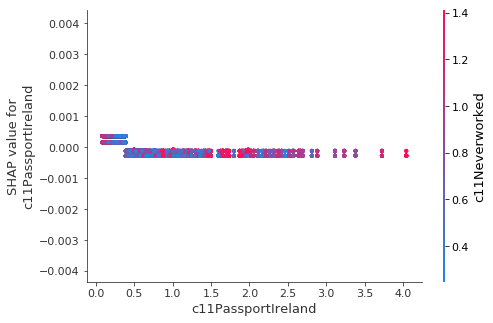

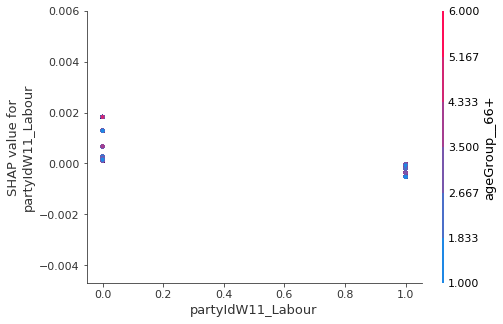

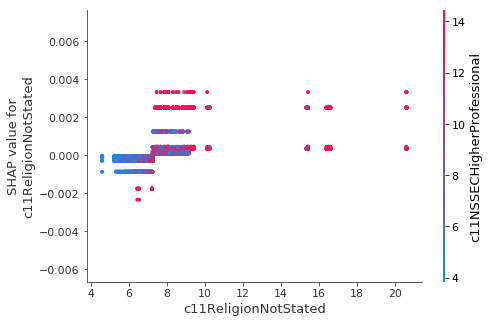

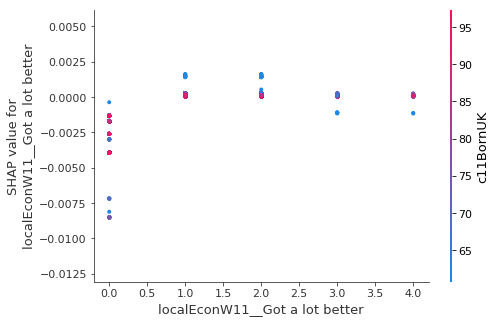

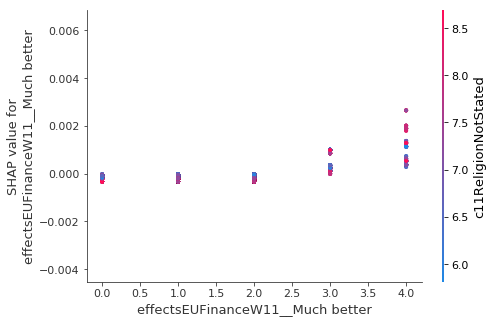

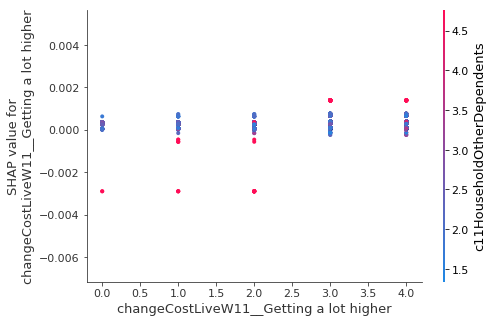

Delta_ptvLabW12 12
missing vals in sample weights: 0
[0]	validation_0-rmse:0.484587
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.468634
[2]	validation_0-rmse:0.45344
[3]	validation_0-rmse:0.439066
[4]	validation_0-rmse:0.425404
[5]	validation_0-rmse:0.412374
[6]	validation_0-rmse:0.399901
[7]	validation_0-rmse:0.387913
[8]	validation_0-rmse:0.376754
[9]	validation_0-rmse:0.366018
[10]	validation_0-rmse:0.356091
[11]	validation_0-rmse:0.346385
[12]	validation_0-rmse:0.337341
[13]	validation_0-rmse:0.328801
[14]	validation_0-rmse:0.320659
[15]	validation_0-rmse:0.312973
[16]	validation_0-rmse:0.305916
[17]	validation_0-rmse:0.299202
[18]	validation_0-rmse:0.292709
[19]	validation_0-rmse:0.286763
MSE: 0.08, MAE: 0.25, EV: 0.01, R2: -0.94


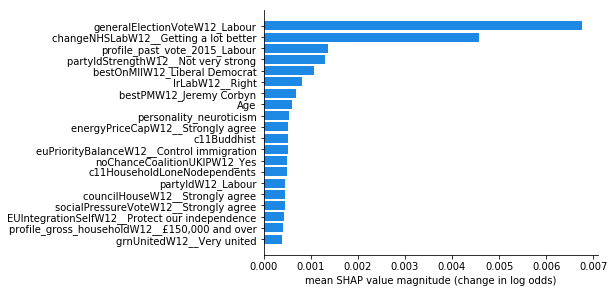

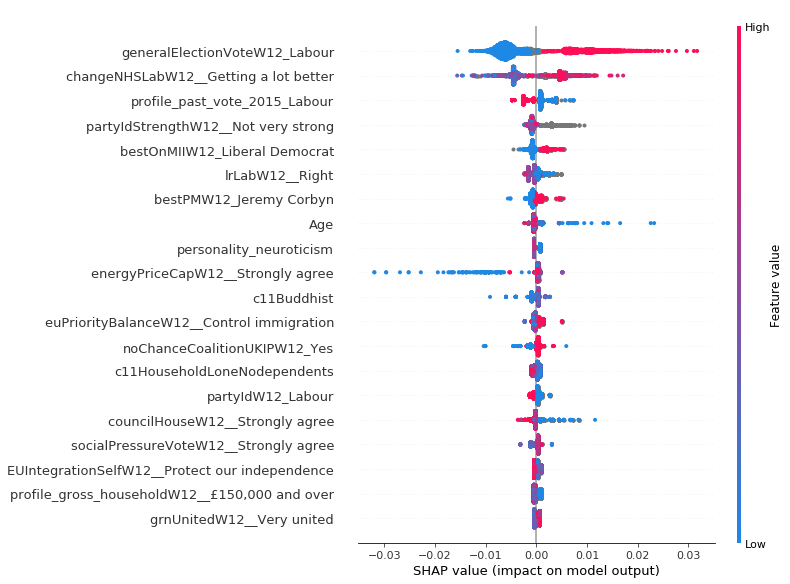

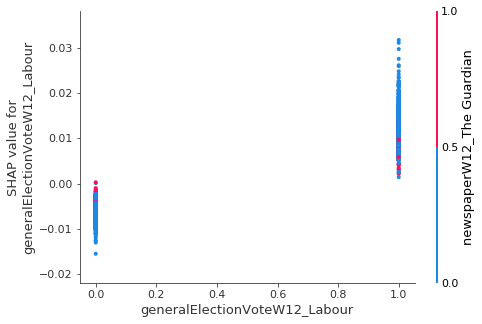

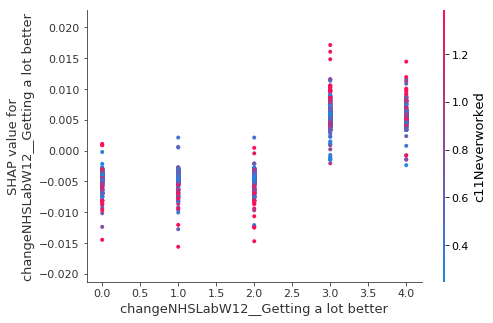

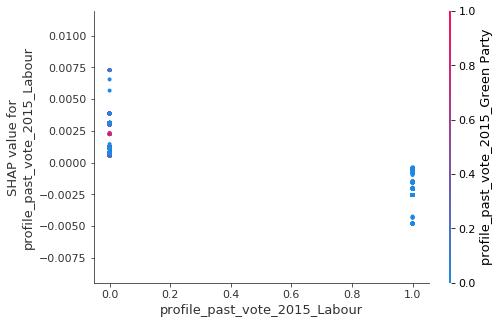

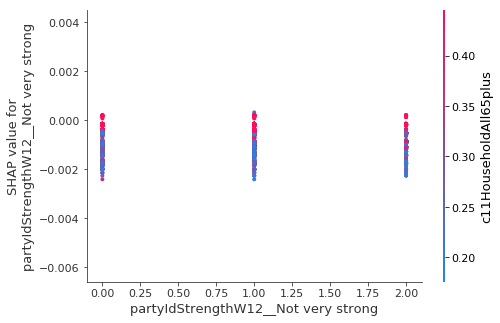

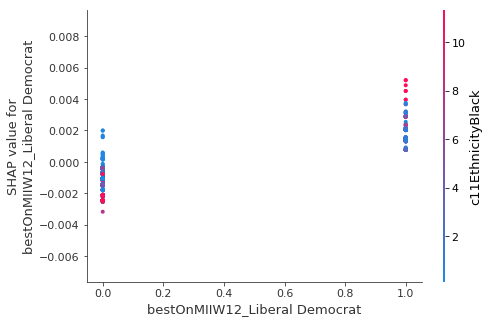

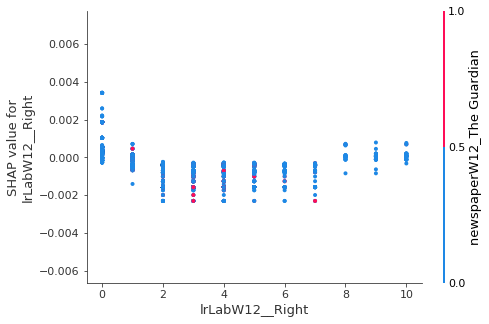

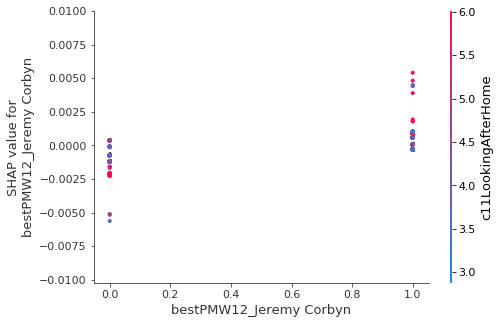

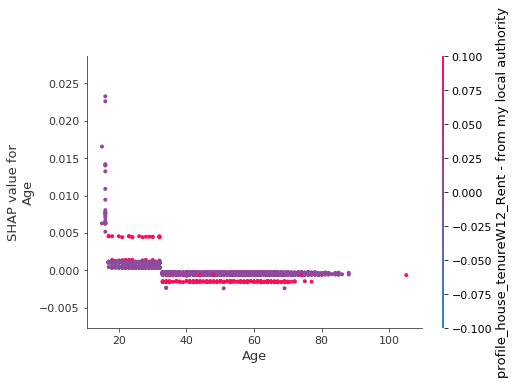

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


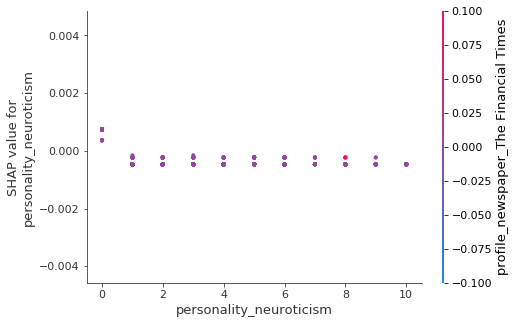

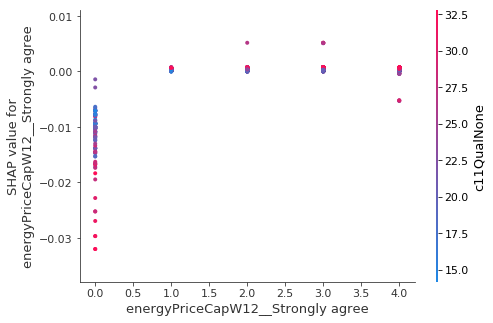

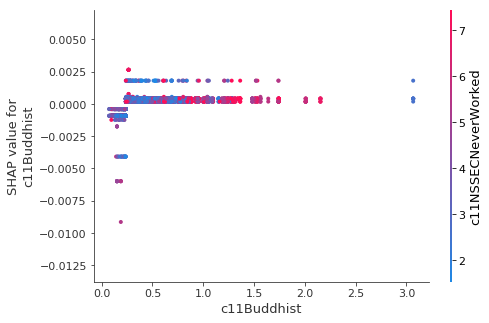

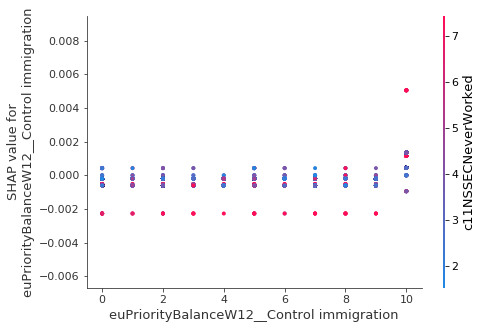

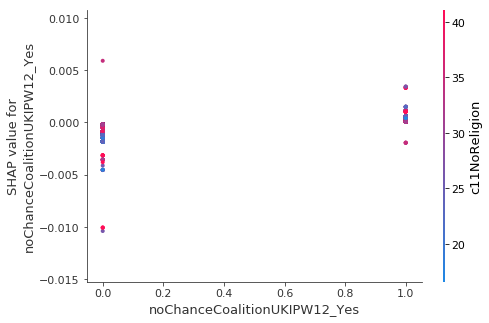

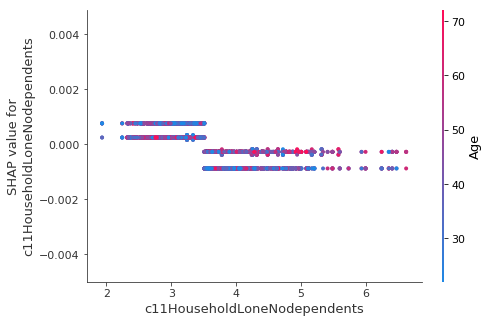

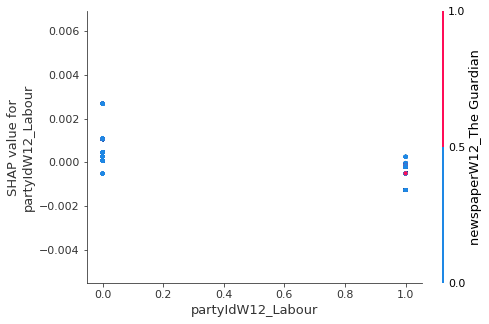

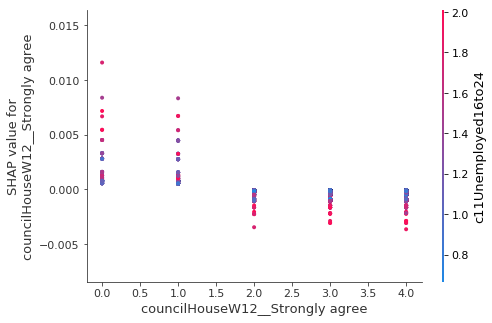

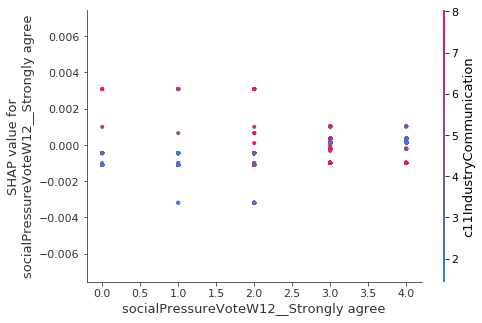

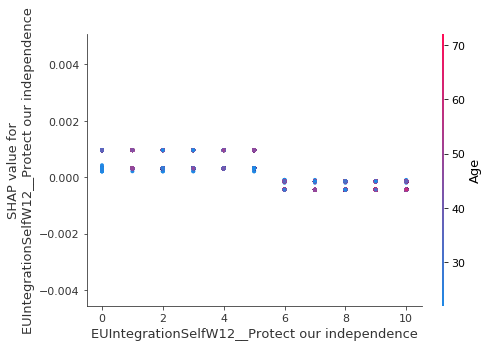

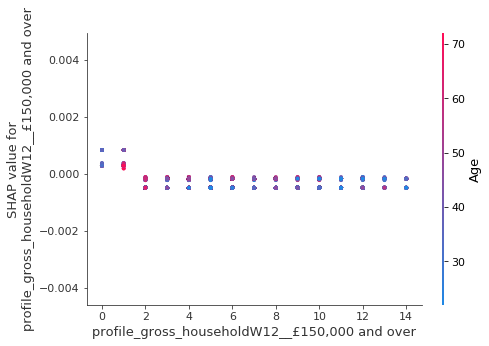

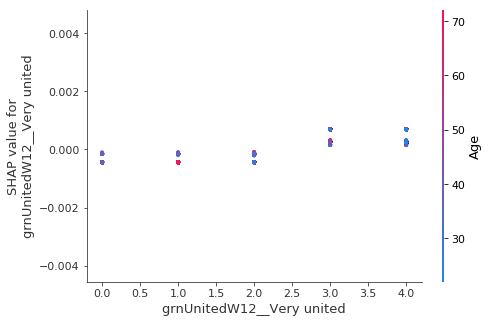

Delta_ptvLabW13 13
missing vals in sample weights: 0
[0]	validation_0-rmse:0.492238
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:0.476002
[2]	validation_0-rmse:0.460545
[3]	validation_0-rmse:0.445843
[4]	validation_0-rmse:0.432047
[5]	validation_0-rmse:0.418841
[6]	validation_0-rmse:0.406298
[7]	validation_0-rmse:0.394406
[8]	validation_0-rmse:0.383209
[9]	validation_0-rmse:0.372463
[10]	validation_0-rmse:0.362248
[11]	validation_0-rmse:0.352543
[12]	validation_0-rmse:0.343403
[13]	validation_0-rmse:0.334772
[14]	validation_0-rmse:0.326618
[15]	validation_0-rmse:0.318871
[16]	validation_0-rmse:0.31171
[17]	validation_0-rmse:0.304954
[18]	validation_0-rmse:0.298589
[19]	validation_0-rmse:0.292485
MSE: 0.09, MAE: 0.25, EV: 0.00, R2: -0.95


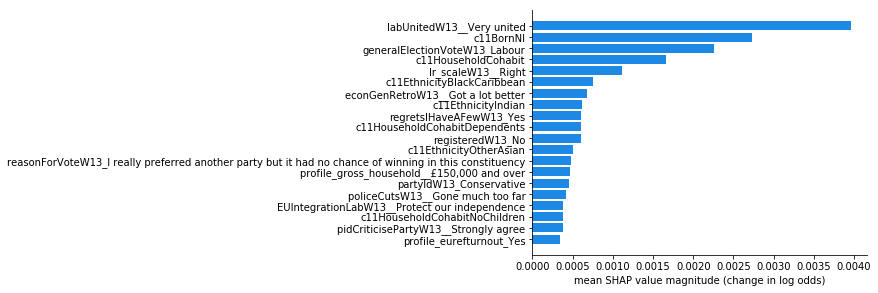

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


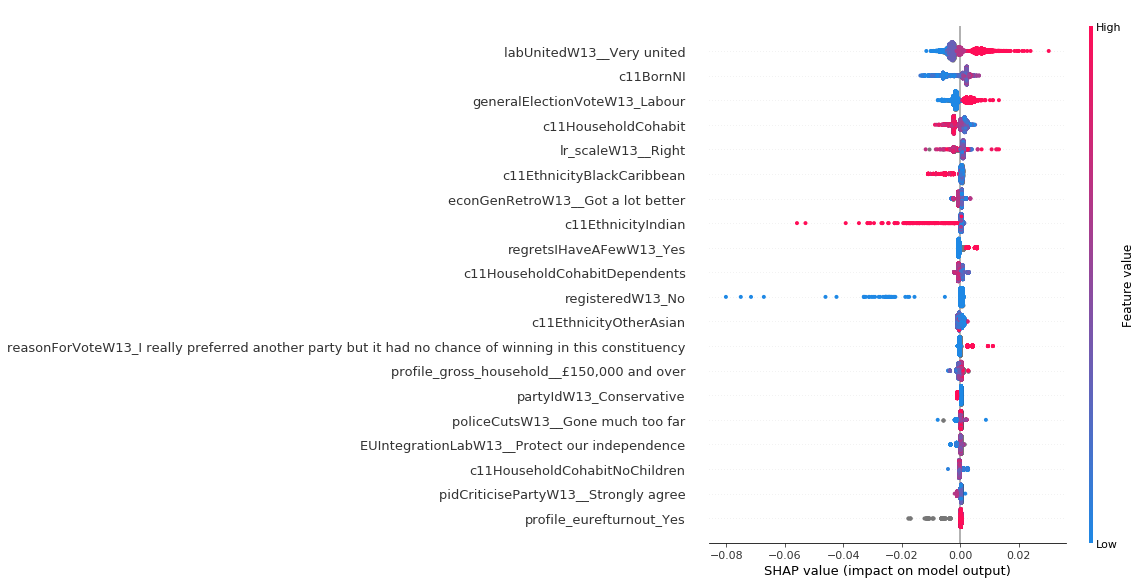

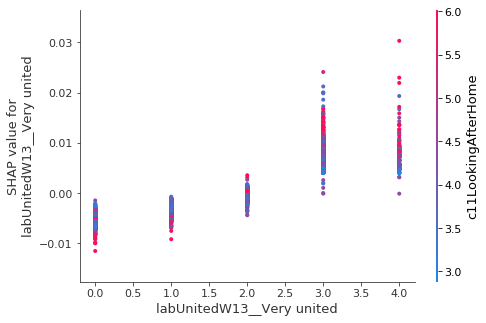

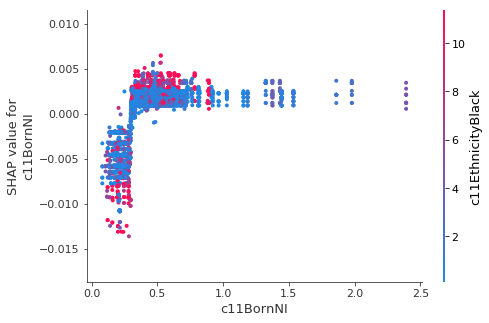

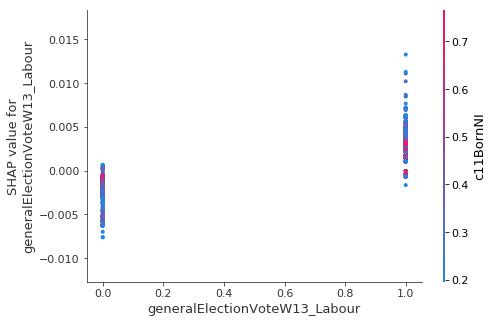

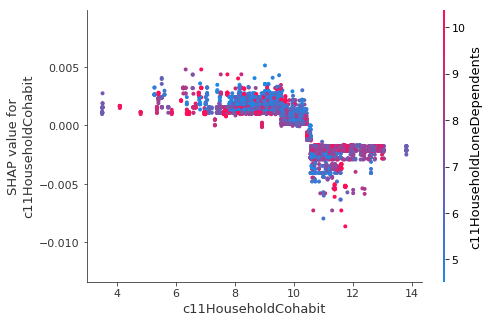

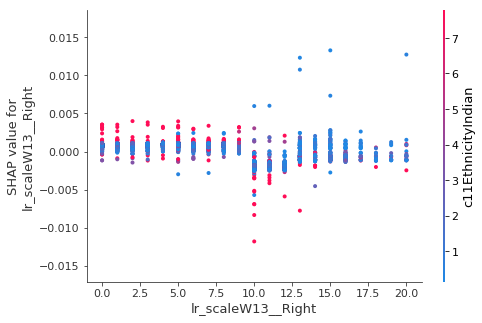

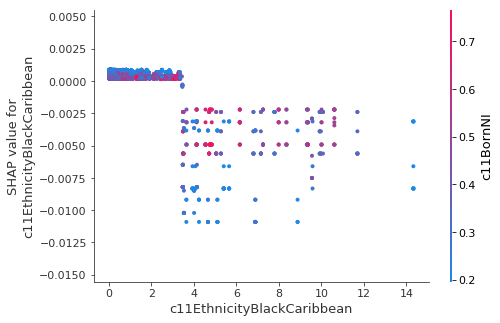

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


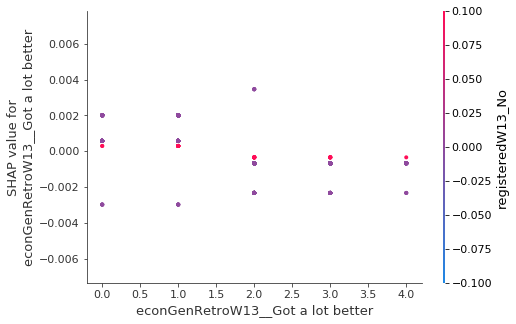

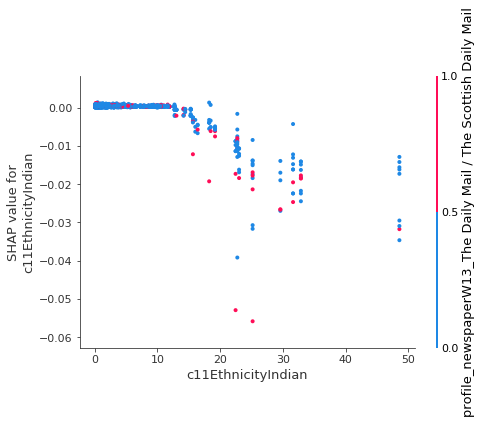

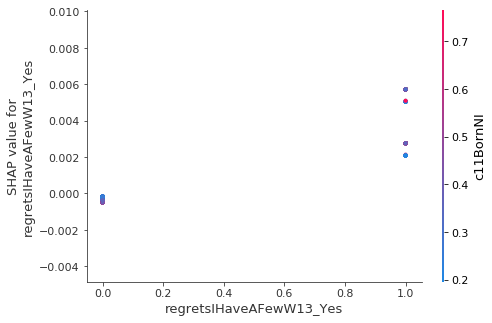

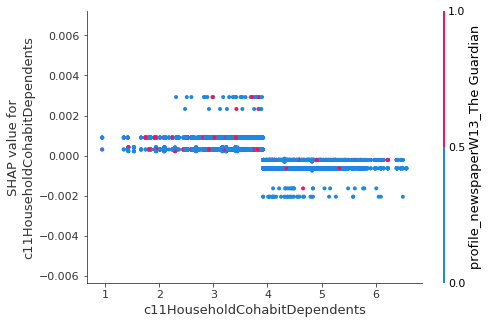

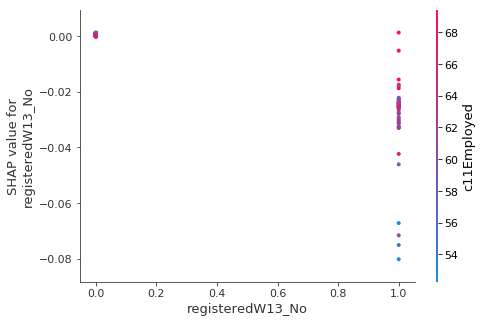

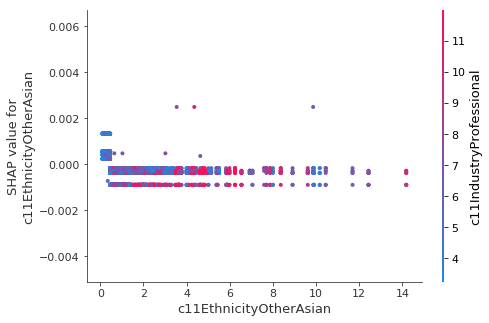

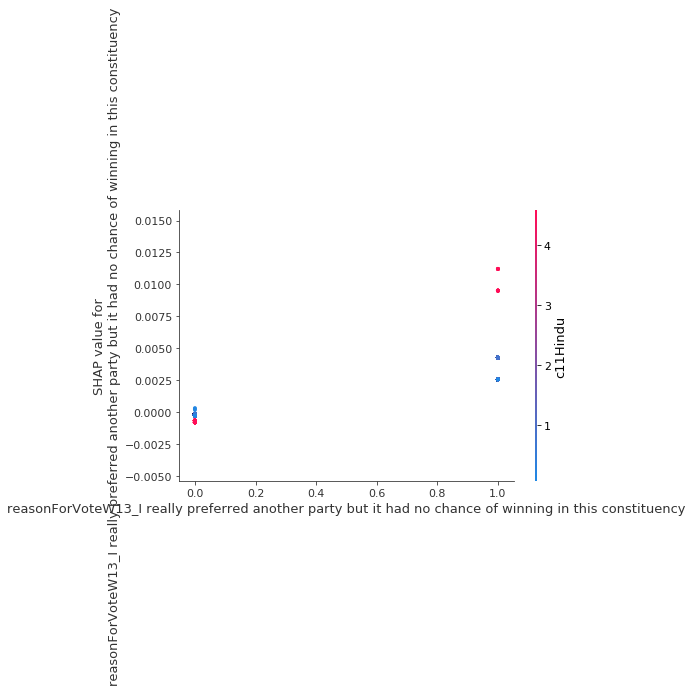

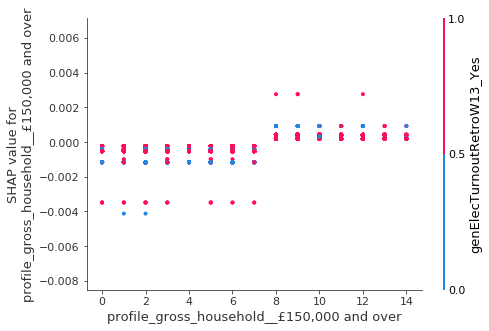

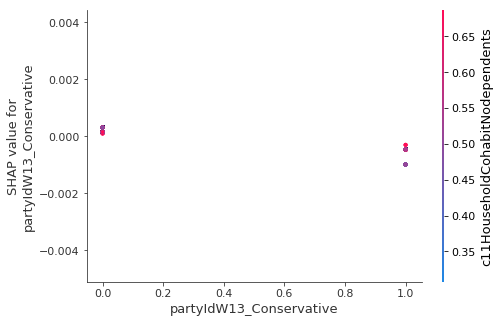

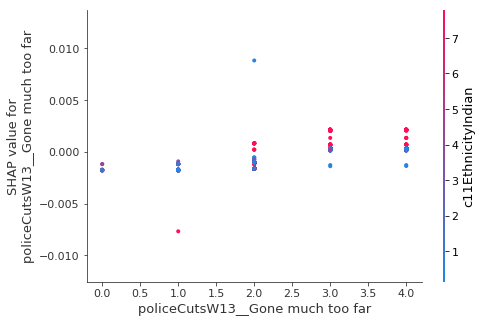

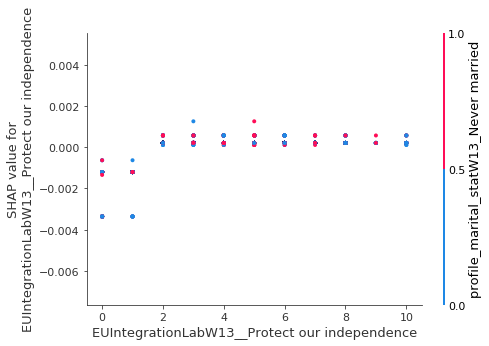

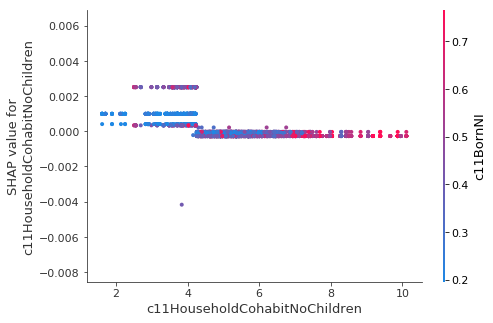

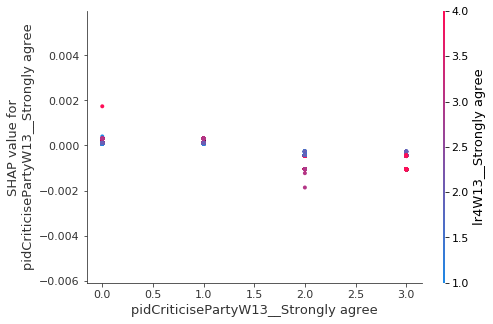

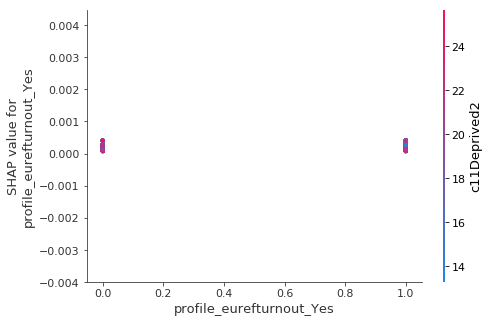

In [45]:
# for target_var,base_var in zip(var_list,base_list):
for target_var in var_list:
    wave_no = int( re.search( 'W(\d+)$', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]    
#     mask = BES_reduced_with_na[target_var].notnull()
#     target = BES_reduced_with_na[target_var][mask]
    
    mask = immigDiff[target_var].notnull()
    if sum(mask)<100:
        continue
    target = immigDiff[target_var][mask]
    
    train  = BES_reduced_with_na[mask]
    
    # drop variables from other waves
    other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9-]|$)"
    train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )       
    
    for var_stub in var_stub_list:
        train = train.drop([x for x in train.columns if var_stub in x], axis=1)    

    wave_no = int( re.search( 'W(\d+)($|__)', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]
    print( target_var, wave_no )    

    sample_weights = weights[weight_var][mask]
    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())

    output_subfolder = BES_output_folder + "xgboost_"+Treatment + os.sep + target_var.replace(">","") + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


    ############################

    alg = XGBRegressor(
     learning_rate =0.04,
     n_estimators= 20,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.75,
     colsample_bytree=0.9,
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=27)

    # split data into train and test sets
    # fit, validate and find overfitting limit
    seed = 7
    test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



    eval_set = [(X_test, y_test)]

    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)

    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

    ####################################
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)




    shap_values = shap.TreeExplainer(alg).shap_values(train);


    #################################
    threshold = .1
    min_features = 20
    global_shap_vals = np.abs(shap_values).mean(0)[:-1]
    n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
    if n_top_features <min_features:
        n_top_features = min_features



    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

    plt.show()

    ####################
    fig = plt.figure()
    shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
    fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')



    ##################
    count = 0
    for name in train.columns[inds[::-1]]:
        fig = plt.figure(figsize = (16,10))    
        shap.dependence_plot(name, shap_values, train)
        fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_")[0:30] + ".png", bbox_inches='tight')
        count = count + 1

In [37]:
immigDiff.notnull().sum()

Delta_ptvLabW2      6740
Delta_ptvLabW3     11993
Delta_ptvLabW4     11806
Delta_ptvLabW5     14108
Delta_ptvLabW6     14070
Delta_ptvLabW7     10593
Delta_ptvLabW8         4
Delta_ptvLabW9      6543
Delta_ptvLabW10    19380
Delta_ptvLabW11    21990
Delta_ptvLabW12     6320
Delta_ptvLabW13     6589
dtype: int64

In [27]:
del BES_Panel

In [26]:
import gc
gc.collect()

0

'../BES_analysis_output/xgboost_test\\partydiffconlabW5__There is not much difference between them\\'

In [36]:
name.replace("/","_")[0:30]

'conToneW5__5 - Focused mainly '